# <div style="text-align: center; background-color: #F78154; font-family: Lobster;color: black; padding: 14px; line-height: 1;border-radius:14px"> Classification d'images d'espèces de papillons 🦋 </div>
**Auteurs** :
Antoine Quennevat -
Clément Maunory -
Louis Schroll -
Romane Dubois 

# <div style="text-align: center; background-color: #87CEEB; font-family: Lobster;color: black; padding: 14px; line-height: 1;border-radius:14px"> 1. Chargement des libraries et des données📚</div>

In [1]:
## Remove Warnings ## 
import warnings
warnings.filterwarnings("ignore")

## Data ## 
import numpy as np
import pandas as pd 
import os 

## Visualization ## 
import matplotlib.pyplot as plt 

## Image ## 
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator # to augment the training data
from tensorflow.keras.utils import image_dataset_from_directory

## Tensorflow ## 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.applications import ResNet50V2, Xception # pre-trained model
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.losses import SparseCategoricalCrossentropy


In [2]:
train_dir = '../input/butterfly-images40-species/train' 
validation_dir = '../input/butterfly-images40-species/valid' 
test_dir = '../input/butterfly-images40-species/test'

import pathlib

#Define train, test, validation data paths dir 
train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir)
validation_dir = pathlib.Path(validation_dir)

## Load data using Keras

#Define some parameters
batch_size = 64
seed = 56
img_height = 244
img_width = 244
n_train = 9285
steps_per_epoch = n_train//batch_size

#Trainset 
train_ds = image_dataset_from_directory(
  train_dir,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Testset
test_ds = image_dataset_from_directory(
  test_dir,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Validationset
validation_ds = image_dataset_from_directory(
  validation_dir,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12594 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


# <div style="text-align: center; background-color: #87CEEB; font-family: Lobster;color: black; padding: 14px; line-height: 1;border-radius:14px"> 2. Exploration du jeu de données 🧐</div>

In [3]:
df = pd.read_csv('/kaggle/input/butterfly-images40-species/butterflies and moths.csv')  
IMAGE_DIR = '/kaggle/input/butterfly-images40-species'
df['filepaths'] = IMAGE_DIR + '/' + df['filepaths']
df.head()

class id                                          filepaths  labels  \
0         0  /kaggle/input/butterfly-images40-species/train...  ADONIS   
1         0  /kaggle/input/butterfly-images40-species/train...  ADONIS   
2         0  /kaggle/input/butterfly-images40-species/train...  ADONIS   
3         0  /kaggle/input/butterfly-images40-species/train...  ADONIS   
4         0  /kaggle/input/butterfly-images40-species/train...  ADONIS   

  data set  
0    train  
1    train  
2    train  
3    train  
4    train

In [4]:
train_df = df.loc[df['data set'] == 'train']
val_df = df.loc[df['data set'] == 'valid']
test_df = df.loc[df['data set'] == 'test']
print([train_df.shape,val_df.shape,test_df.shape])

[(12594, 4), (500, 4), (500, 4)]


In [5]:
label_counts = df['labels'].value_counts()
print(len(label_counts))

100


L'ensemble du jeu de données contient 13594 images, réparties en trois groupes : les données d'entrainement, de validation et de test.
Parmi ces 13594 images on peut compter 100 espèces différentes de papillons, dont on va représenter un échantillon.

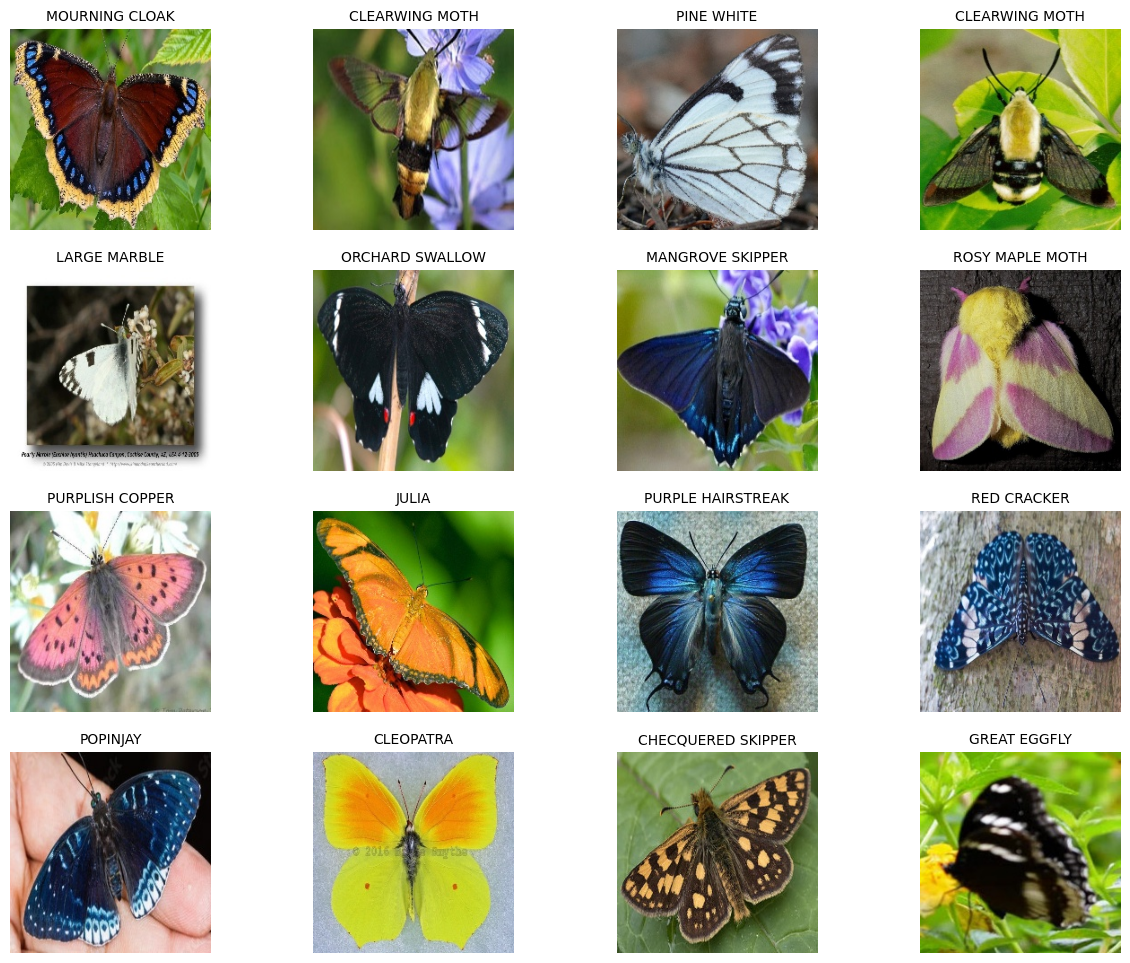

In [6]:
from PIL import Image
plt.figure(figsize=(15,12))
for i, row in val_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['filepaths']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"], fontsize=10)
    plt.axis('off')
plt.show()

On peut facilement voir (et apprécier !) l'impressionnante diversité morphologique des lepidoptères.
Enfin, on regarde combien d'images compte chaque espèces, afin de vérifier que toutes les espèces possèdent suffisamment d'images.

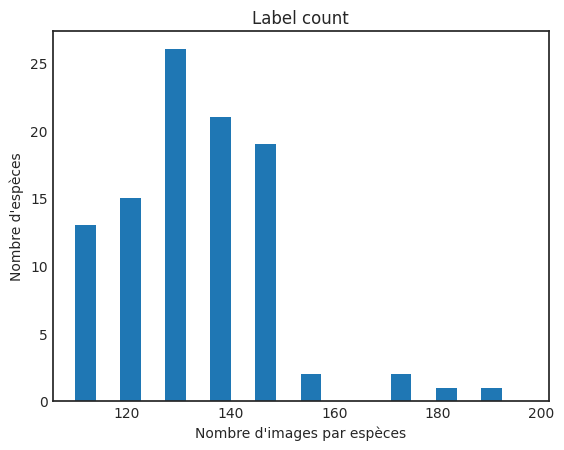

In [7]:
plt.style.use("seaborn-white")
plt.hist(label_counts, width = 4)
plt.title('Label count')
plt.xlabel("Nombre d'images par espèces")
plt.ylabel("Nombre d'espèces")
plt.show()

Globalement, on possède entre 110 et 190 images environ par espèces. C'est très bien.

# <div style="text-align: center; background-color: #87CEEB; font-family: Lobster;color: black; padding: 14px; line-height: 1;border-radius:14px"> 3. Home made model 🏠 </div>

On définit d'abord une fonction pour compiler et entrainer les différents modèles que l'on va tester et plusieurs fonctions pour la réalisation des graphiques.

In [8]:
def compile_and_train(model, name, train_data=train_ds, nb_epochs=15):
    """function to compile and train each model that we are going to test.
    Output : training history"""
    # compile the model
    model.compile(optimizer = 'adam',
                  loss = SparseCategoricalCrossentropy(from_logits=True),
                  metrics = ['accuracy'])
    
    # train the model 
    history = model.fit(
        train_data,
        validation_data = validation_ds,
        epochs = nb_epochs)
    
    return history

In [9]:
def generate_model_colors(m_histories):
    """Get a list of color for each model"""
    model_names = list(m_histories.keys())
    color_map = plt.cm.inferno
    model_colors = {model_name: color_map(i / len(model_names)) for i, model_name in enumerate(model_names)}
    return model_colors


def plot_accuracy(m_histories):
    """Plot training and validation accuracy"""
    plt.clf()
    plt.style.use('fast')
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 6))
    
    model_colors = generate_model_colors(m_histories)
    
    for model_name, history in m_histories.items():
        color = model_colors[model_name]
        plt.plot(history.history['accuracy'], color=color, linewidth=1)
        plt.plot(history.history['val_accuracy'], "--", color=color, linewidth=1)

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(axis='y', alpha=0.3)
    plt.gca().spines[['left', 'right', 'top']].set_visible(False)
    plt.legend(loc='lower right')
    plt.show()         
               
def plot_loss(m_histories):
    """Plot training and validation loss"""
    plt.clf()
    plt.style.use('fast')
    plt.figure(figsize=(12, 6))
    
    model_colors = generate_model_colors(m_histories)
    for model_name, history in m_histories.items():
        color = model_colors[model_name]
        plt.plot(history.history['loss'], label=f'{model_name} Training Loss', color=color, linewidth=1)
        plt.plot(history.history['val_loss'],"r--", label=f'{model_name} Validation Loss', color=color, linewidth=1)
        
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(axis='y', alpha=0.3)
    plt.gca().spines[['left', 'right', 'top']].set_visible(False)

    plt.show()
    return None



# <div style="text-align: left; background-color: #A2CBA7; font-family: Lobster;color: black; padding: 14px; line-height: 0.5;border-radius:14px; font-size: 20px"> 3.1. Le modèle de base </div>

On commence un premier modèle simple avec l'architecture suivante : 
* 3 couches de Convolutions et Maxpooling
* 1 couche Flatten
* 2 couches Denses

On va l'entrainer sur **15** epochs et un batch size de **64**. Nous avons utilisa la fonction de **crossentropy** comme la fonction de coût , et l'optimiseur **Adam**.

In [10]:
# Define the number of classes 
num_classes = len(train_ds.class_names)

simple_model = Sequential([
  Rescaling(1./255),
  Conv2D(16, 3, activation='relu'),
  MaxPooling2D(2),
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(2),
  Conv2D(64, 3, activation='relu'),
  MaxPooling2D(2),
  Flatten(),
  Dense(512, activation='relu'),
  Dense(num_classes, activation='softmax') 
])

#Train and store the history from the simple model in a dictionnary
model_histories = {} 
model_histories['Simple'] = compile_and_train(simple_model, 'model/simple')

Epoch 1/15
197/197 [==============================] - 41s 140ms/step - loss: 3.1726 - accuracy: 0.2615 - val_loss: 1.8105 - val_accuracy: 0.5120
Epoch 2/15
197/197 [==============================] - 15s 73ms/step - loss: 1.3869 - accuracy: 0.6370 - val_loss: 1.3727 - val_accuracy: 0.6300
Epoch 3/15
197/197 [==============================] - 16s 79ms/step - loss: 0.5634 - accuracy: 0.8498 - val_loss: 1.5338 - val_accuracy: 0.6640
Epoch 4/15
197/197 [==============================] - 16s 77ms/step - loss: 0.1695 - accuracy: 0.9538 - val_loss: 1.7124 - val_accuracy: 0.6540
Epoch 5/15
197/197 [==============================] - 15s 72ms/step - loss: 0.0895 - accuracy: 0.9774 - val_loss: 1.8814 - val_accuracy: 0.6520
Epoch 6/15
197/197 [==============================] - 15s 75ms/step - loss: 0.0672 - accuracy: 0.9825 - val_loss: 2.0450 - val_accuracy: 0.6480
Epoch 7/15
197/197 [==============================] - 15s 72ms/step - loss: 0.0529 - accuracy: 0.9854 - val_loss: 2.0349 - val_accuracy

<Figure size 640x480 with 0 Axes>

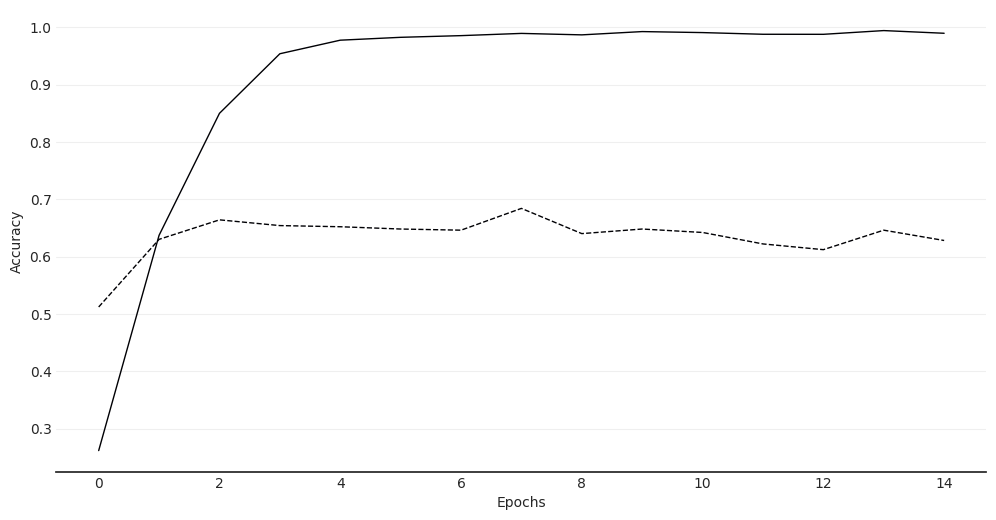

<Figure size 640x480 with 0 Axes>

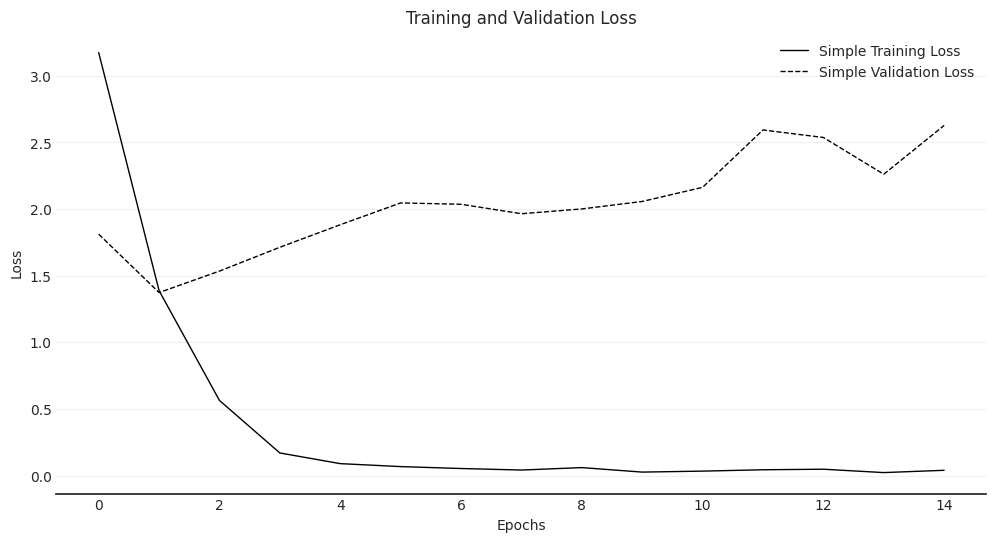

In [11]:
# Plot loss and accuracy for the first model
plot_accuracy(model_histories)
plot_loss(model_histories)

In [12]:
results = simple_model.evaluate(test_ds, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 2.36702
Test Accuracy: 65.40%


Les plots montre un sur-ajustement du modèle , les modèle est sur-entrainé sur le jeu de données d'entrainement et n'arrive pas à aussi bien classer le jeu de données de validation. On va voir dans la suite comment réduire cet **overfitting**. Quant au test avec le jeu de données test on obtient une précision de **56%**. De même on va chercher ensuite à obtenir un modèle plus performant.

# <div style="text-align: left; background-color: #A2CBA7; font-family: Lobster;color: black; padding: 14px; line-height: 0.5;border-radius:14px; font-size: 20px"> 3.2. Réduction de l'overfitting par modification de la structure du mod </div>

In [13]:
improved_model = Sequential([
  Rescaling(1./255),
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(2),
  Conv2D(64, 3, activation='relu'),
  MaxPooling2D(2),
  Conv2D(128, 3, activation='relu'),
  MaxPooling2D(2),
  Conv2D(128, 3, activation='relu'),
  MaxPooling2D(2),
  Flatten(),
  Dense(512, activation='relu'),
  Dense(num_classes, activation='softmax') 
])

#Train and store the history from the simple model in a dictionnary
model_histories['Improved'] = compile_and_train(improved_model, 'model/improved')

Epoch 1/15
197/197 [==============================] - 29s 124ms/step - loss: 3.4567 - accuracy: 0.1991 - val_loss: 2.1247 - val_accuracy: 0.4840
Epoch 2/15
197/197 [==============================] - 22s 111ms/step - loss: 1.6687 - accuracy: 0.5646 - val_loss: 1.4795 - val_accuracy: 0.6060
Epoch 3/15
197/197 [==============================] - 22s 111ms/step - loss: 0.8641 - accuracy: 0.7612 - val_loss: 1.4220 - val_accuracy: 0.6700
Epoch 4/15
197/197 [==============================] - 22s 111ms/step - loss: 0.4063 - accuracy: 0.8833 - val_loss: 1.3804 - val_accuracy: 0.7000
Epoch 5/15
197/197 [==============================] - 22s 111ms/step - loss: 0.2119 - accuracy: 0.9378 - val_loss: 1.7767 - val_accuracy: 0.6900
Epoch 6/15
197/197 [==============================] - 22s 111ms/step - loss: 0.1372 - accuracy: 0.9603 - val_loss: 2.1625 - val_accuracy: 0.6840
Epoch 7/15
197/197 [==============================] - 22s 110ms/step - loss: 0.0979 - accuracy: 0.9721 - val_loss: 2.2282 - val_ac

<Figure size 640x480 with 0 Axes>

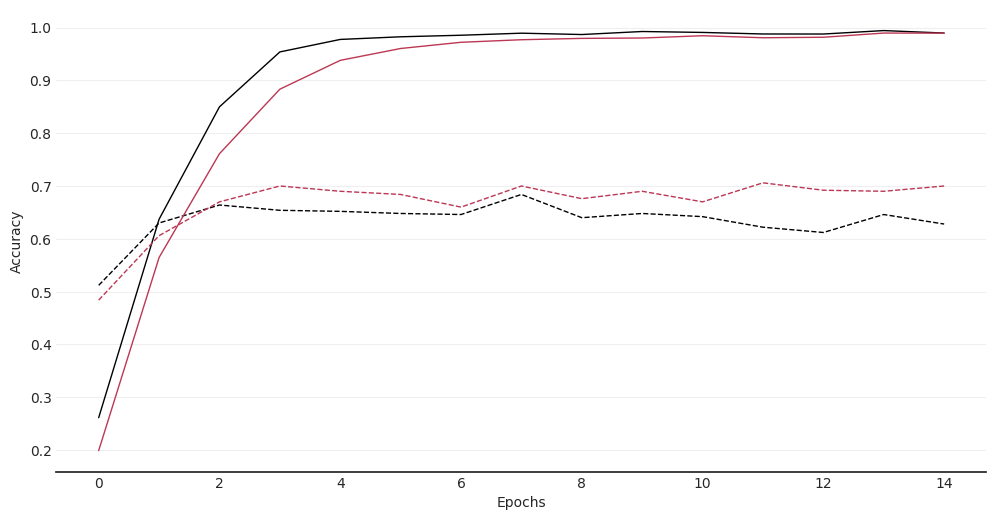

<Figure size 640x480 with 0 Axes>

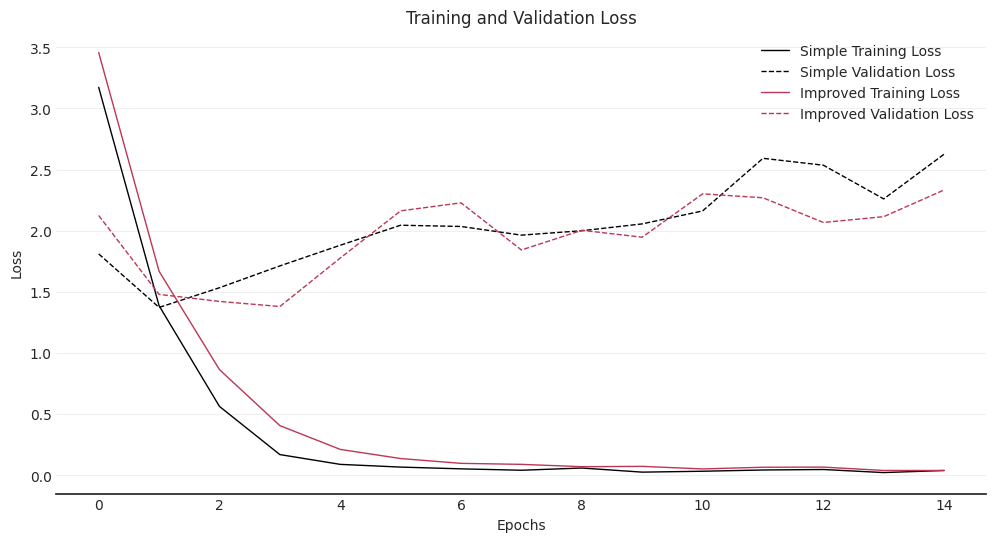

In [14]:
# Plot loss and accuracy for the first two models
plot_accuracy(model_histories)
plot_loss(model_histories)

Souvent le surajustement se produit lorsque le modèle est trop complexe, il est alors logique de réduire le nombre de paramètres. Mais, en général, nous ne savons pas quelles fonctionnalités supprimer de notre modèle,c'est pourquoi on utilise des méthodes de régularisation. Nous allons voir différentes méthodes ici : régularisation L2, drop out et batch normalisation.

# <div style="text-align: left; background-color: #A2CBA7; font-family: Lobster;color: black; padding: 14px; line-height: 0.5;border-radius:14px; font-size: 20px"> 3.2. Réduction de l'overfitting avec une régularisation f2 </div>

La Regularization Weight Decay (Diminution des Poids en français) est une des technique qui permet d’améliorer la généralisation lors de l’apprentissage du modèle. Le principe est d'ajouter un terme pénalisant la complexité du modèle dans la fonction de coût, de façon à ce que lors de l'entrainement, on cherche à minimiser la fonction de cout + la complexité du modèle. La pénalité est calculée à partir des poids du modèle. Par exemple, la régularisation L2 fonctionne en ajoutant une pénalité proportionnelle au carré des valeurs des coefficients du modèle. Concrètement, cela signifie que les termes ayant des coefficients plus élevés contribuent davantage à la fonction de coût, ce qui encourage le modèle à maintenir les coefficients à des niveaux plus modestes. Cette pénalité L2 a l'effet de décourager les coefficients de devenir trop grands, limitant ainsi la complexité du modèle, ce qui favorise la généralisation du modèle sur de nouvelles données.

Pour l'appliquer concrètement avec Keras, on utilise l'argument kernel_regularizer=regularizers.l2(lambda_par) au seain de chaque couche. Cela applique une pénalité sur le noyau de la couche. Le paramètre lambda est le paramètre de régularisation, également appelé facteur de régularisation. Ce paramètre contrôle l'intensité de la régularisation. Plus la valeur est grande, plus la pénalité sur les poids du modèle sera forte.

In [15]:
lambda_par = 0.001

#Improved model with l2 regularizaton
model_l2 = Sequential([
  Rescaling(1./255),
  Conv2D(32, 3, activation='relu',kernel_regularizer=regularizers.l2(lambda_par)),
  MaxPooling2D(),
  Conv2D(64, 3, activation='relu',kernel_regularizer=regularizers.l2(lambda_par)),
  MaxPooling2D(),
  Conv2D(128, 3, activation='relu',kernel_regularizer=regularizers.l2(lambda_par)),
  MaxPooling2D(),
  Conv2D(128, 3, activation='relu',kernel_regularizer=regularizers.l2(lambda_par)),
  MaxPooling2D(),
  Flatten(),
  Dense(512, activation='relu',kernel_regularizer=regularizers.l2(lambda_par)),
  Dense(num_classes, activation = 'softmax')
])

# train and store the data
regularizer_histories = {}
regularizer_histories['Improved'] = model_histories['Improved']
regularizer_histories['l2'] = compile_and_train(model_l2, 'model/l2')

Epoch 1/15
197/197 [==============================] - 25s 112ms/step - loss: 3.7226 - accuracy: 0.2179 - val_loss: 2.4768 - val_accuracy: 0.5080
Epoch 2/15
197/197 [==============================] - 23s 112ms/step - loss: 2.3330 - accuracy: 0.5112 - val_loss: 2.0626 - val_accuracy: 0.5840
Epoch 3/15
197/197 [==============================] - 22s 112ms/step - loss: 1.7870 - accuracy: 0.6692 - val_loss: 2.0516 - val_accuracy: 0.6480
Epoch 4/15
197/197 [==============================] - 22s 112ms/step - loss: 1.4764 - accuracy: 0.7762 - val_loss: 2.1294 - val_accuracy: 0.6580
Epoch 5/15
197/197 [==============================] - 22s 112ms/step - loss: 1.2542 - accuracy: 0.8562 - val_loss: 2.2721 - val_accuracy: 0.6860
Epoch 6/15
197/197 [==============================] - 23s 112ms/step - loss: 1.1521 - accuracy: 0.8881 - val_loss: 2.2694 - val_accuracy: 0.6860
Epoch 7/15
197/197 [==============================] - 23s 112ms/step - loss: 1.1005 - accuracy: 0.9110 - val_loss: 2.4485 - val_ac

<Figure size 640x480 with 0 Axes>

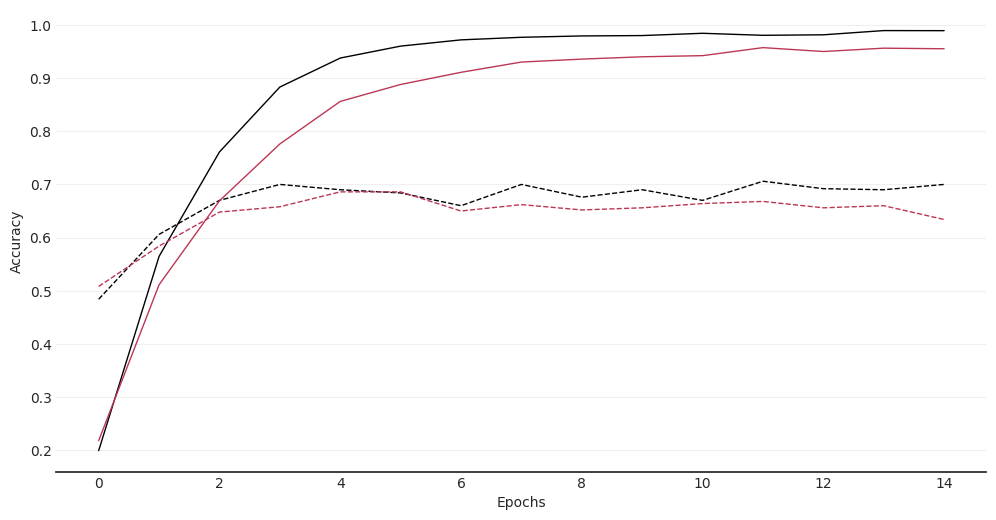

<Figure size 640x480 with 0 Axes>

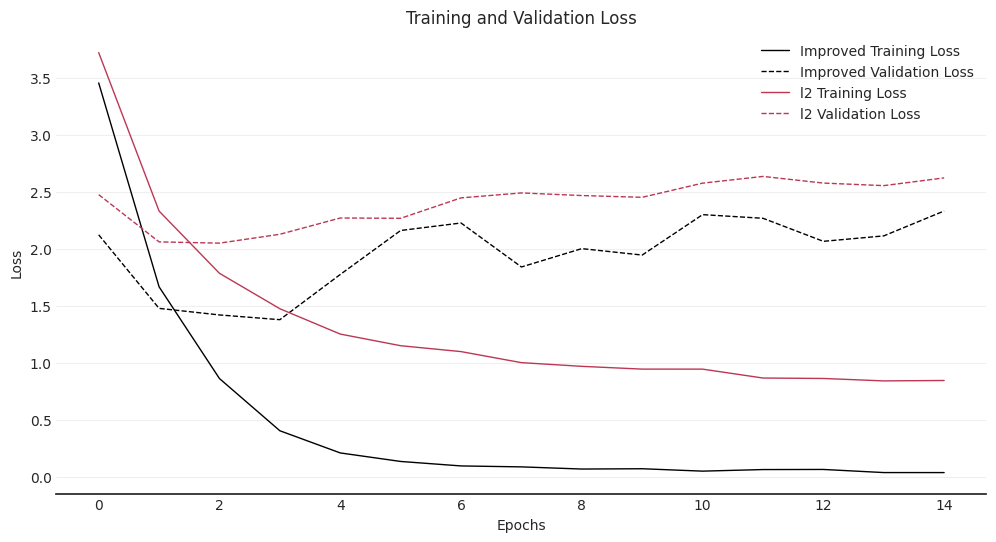

In [16]:
# Plot loss and accuracy
plot_accuracy(regularizer_histories)
plot_loss(regularizer_histories)

# <div style="text-align: left; background-color: #A2CBA7; font-family: Lobster;color: black; padding: 14px; line-height: 0.5;border-radius:14px; font-size: 20px"> 3.3. Réduction de l'overfitting avec batch normalisation </div>

La batch normalization, ou normalisation par lot en français, est une autre technique pour diminuer le sur-ajustement très utilisée en deep learning. Elle consiste à modifier les données en sortie de chaque couche de neurones pour que la moyenne soit nulle et la variance égale à 1. Comme la sortie de chaque couche est l'entrée de la couche suivante, intercaler une batch normalisation entre permet aide à atténuer les problèmes liés à des changements de distribution des données à travers différentes couches du réseau. En normalisant les entrées d'une couche, la Batch Normalization contribue à réduire le problème du décalage covariant, améliorant ainsi la capacité du réseau à généraliser sur différentes instances de données. 

Avec Keras, on aura simplement à ajouter entre les couches : BatchNormalization().

In [17]:
# Improved model with BatchNormalization 
model_bn = Sequential([
  Rescaling(1./255),
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(),
  BatchNormalization(),
  Conv2D(64, 3, activation='relu'),
  MaxPooling2D(),
  BatchNormalization(),
  Conv2D(128, 3, activation='relu'),
  MaxPooling2D(),
  BatchNormalization(),
  Conv2D(128, 3, activation='relu'),
  MaxPooling2D(),
  BatchNormalization(),
  Flatten(),
  Dense(512, activation='relu'),
  BatchNormalization(),
  Dense(num_classes, activation = 'softmax')
])

#Training the model with BatchNormalization
regularizer_histories['BatchNormalization'] = compile_and_train(model_bn, 'model/BatchNormalization')

Epoch 1/15
197/197 [==============================] - 29s 125ms/step - loss: 2.1097 - accuracy: 0.4794 - val_loss: 8.6280 - val_accuracy: 0.0200
Epoch 2/15
197/197 [==============================] - 25s 125ms/step - loss: 0.6856 - accuracy: 0.8192 - val_loss: 2.7962 - val_accuracy: 0.3220
Epoch 3/15
197/197 [==============================] - 25s 124ms/step - loss: 0.1705 - accuracy: 0.9637 - val_loss: 0.9684 - val_accuracy: 0.7460
Epoch 4/15
197/197 [==============================] - 25s 123ms/step - loss: 0.0445 - accuracy: 0.9936 - val_loss: 0.7586 - val_accuracy: 0.8080
Epoch 5/15
197/197 [==============================] - 25s 124ms/step - loss: 0.0203 - accuracy: 0.9980 - val_loss: 0.7665 - val_accuracy: 0.7960
Epoch 6/15
197/197 [==============================] - 25s 124ms/step - loss: 0.0086 - accuracy: 0.9993 - val_loss: 0.7300 - val_accuracy: 0.8160
Epoch 7/15
197/197 [==============================] - 25s 123ms/step - loss: 0.0046 - accuracy: 0.9994 - val_loss: 0.7468 - val_ac

<Figure size 640x480 with 0 Axes>

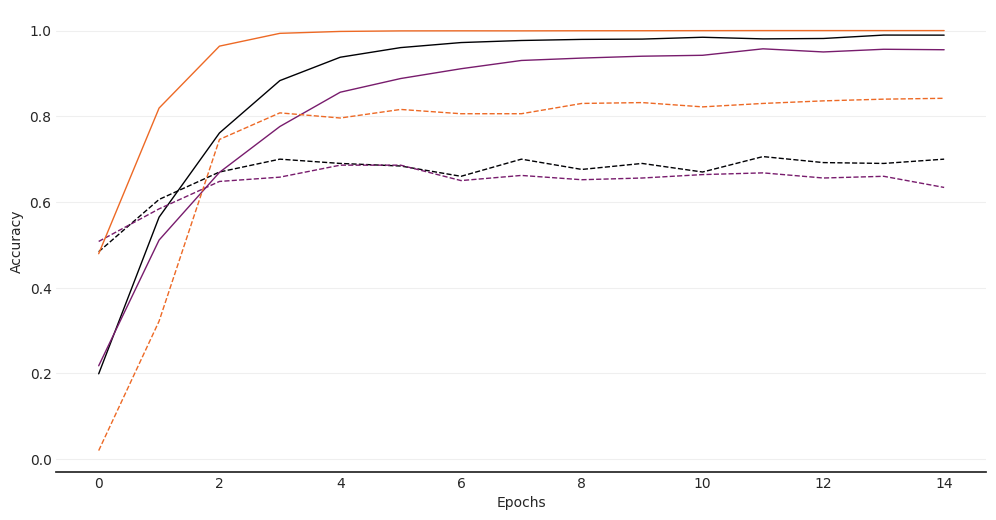

<Figure size 640x480 with 0 Axes>

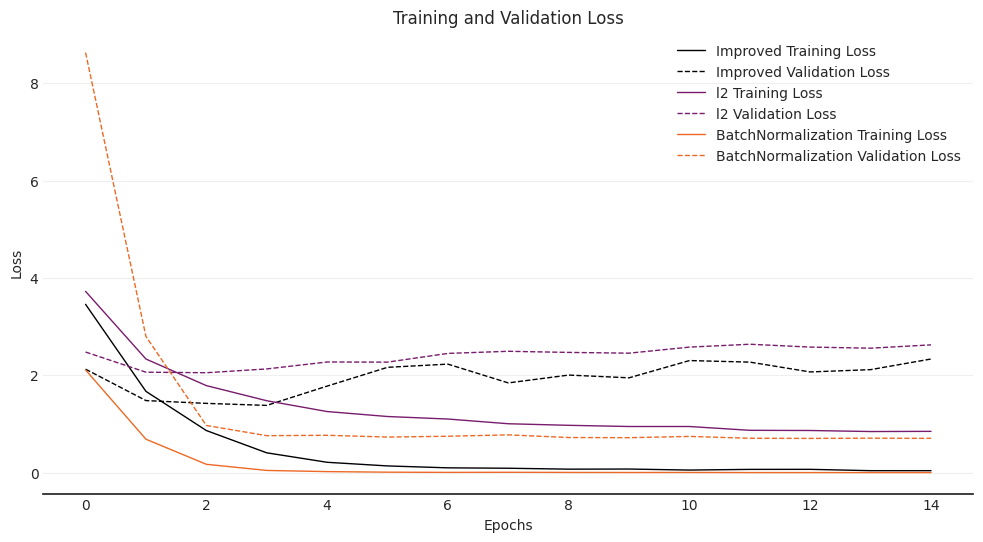

In [18]:
# Plot loss and accuracy
plot_accuracy(regularizer_histories)
plot_loss(regularizer_histories)

# <div style="text-align: left; background-color: #A2CBA7; font-family: Lobster;color: black; padding: 14px; line-height: 0.5;border-radius:14px; font-size: 20px"> 3.4. Réduction de l'overfitting avec dropout </div>

Le dropout est une technique populaire de régularisation utilisée dans les réseaux neuronaux pour prévenir le surajustement. Lors de l'entraînement, le dropout consiste à aléatoirement "éteindre" un certain pourcentage de neurones dans une couche, c'est-à-dire ignorer leur contribution pendant cette itération spécifique de l'apprentissage. Cela force le réseau à ne pas trop dépendre de certains neurones particuliers, améliorant ainsi sa robustesse et sa capacité à généraliser sur de nouvelles données et évite qu'il ne se spécialise excessivement dans des motifs particuliers des données d'entraînement. Pour compenser le drop out, qui réduit le nombre de neurones actifs pendant l'entrainement, Keras multiplie les sorties des neurones par un facteur de 1/(1 - taux de dropout). Cela permet de maintenir la même échelle d'activations lorsque le modèle sera utilisé en dehors de l'entrainement. 

Avec Keras, on utilise Dropout(dropout_rate) en sortie de chaque couche. Le paramètre dropout_rate est le taux de neurones qui seront éteint en moyenne, autrement dit c'est la probabilité pour un neurone d'être éteint.

In [19]:
dropout_rate = 0.4

#Improved model with dropout regularization
model_dropout = Sequential([
  Rescaling(1./255),
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(),
  Dropout(dropout_rate),
  Conv2D(64, 3, activation='relu'),
  MaxPooling2D(),
  Dropout(dropout_rate),
  Conv2D(128, 3, activation='relu'),
  MaxPooling2D(),
  Dropout(dropout_rate),
  Conv2D(128, 3, activation='relu'),
  MaxPooling2D(),
  Dropout(dropout_rate),
  Flatten(),
  Dense(512, activation='relu'),
  Dropout(dropout_rate),
  Dense(num_classes, activation = 'softmax')
])

# train and store the data
regularizer_histories['dropout'] = compile_and_train(model_dropout, 'model/dropout')

Epoch 1/15


2023-11-15 12:40:22.385743: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


197/197 [==============================] - 42s 200ms/step - loss: 4.4325 - accuracy: 0.0324 - val_loss: 4.0363 - val_accuracy: 0.1080
Epoch 2/15
197/197 [==============================] - 39s 195ms/step - loss: 3.4910 - accuracy: 0.1867 - val_loss: 2.7496 - val_accuracy: 0.3580
Epoch 3/15
197/197 [==============================] - 39s 196ms/step - loss: 2.4957 - accuracy: 0.3780 - val_loss: 1.9370 - val_accuracy: 0.5260
Epoch 4/15
197/197 [==============================] - 39s 195ms/step - loss: 1.8757 - accuracy: 0.5112 - val_loss: 1.7100 - val_accuracy: 0.5580
Epoch 5/15
197/197 [==============================] - 39s 196ms/step - loss: 1.4868 - accuracy: 0.6004 - val_loss: 1.4024 - val_accuracy: 0.6220
Epoch 6/15
197/197 [==============================] - 39s 196ms/step - loss: 1.2072 - accuracy: 0.6659 - val_loss: 1.1975 - val_accuracy: 0.6700
Epoch 7/15
197/197 [==============================] - 39s 196ms/step - loss: 0.9908 - accuracy: 0.7157 - val_loss: 1.2775 - val_accuracy: 0.6

<Figure size 640x480 with 0 Axes>

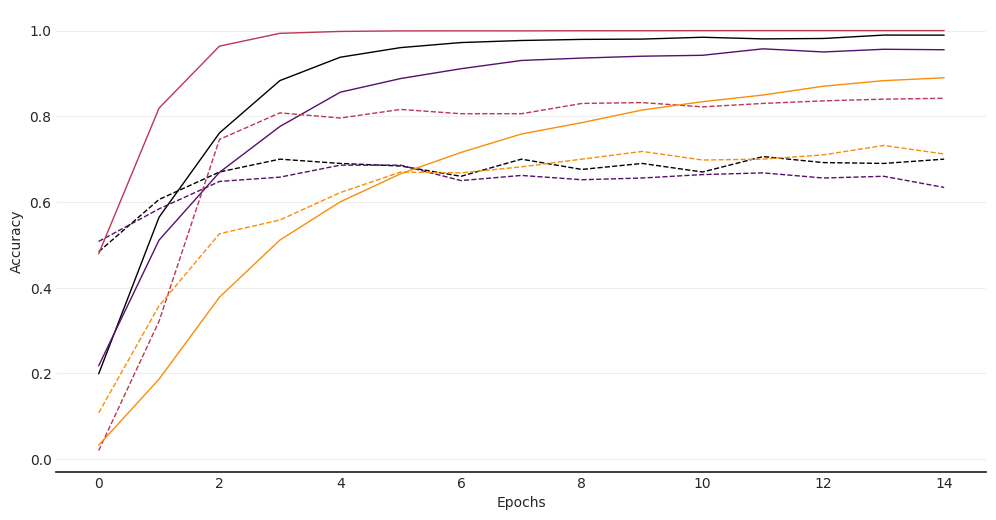

<Figure size 640x480 with 0 Axes>

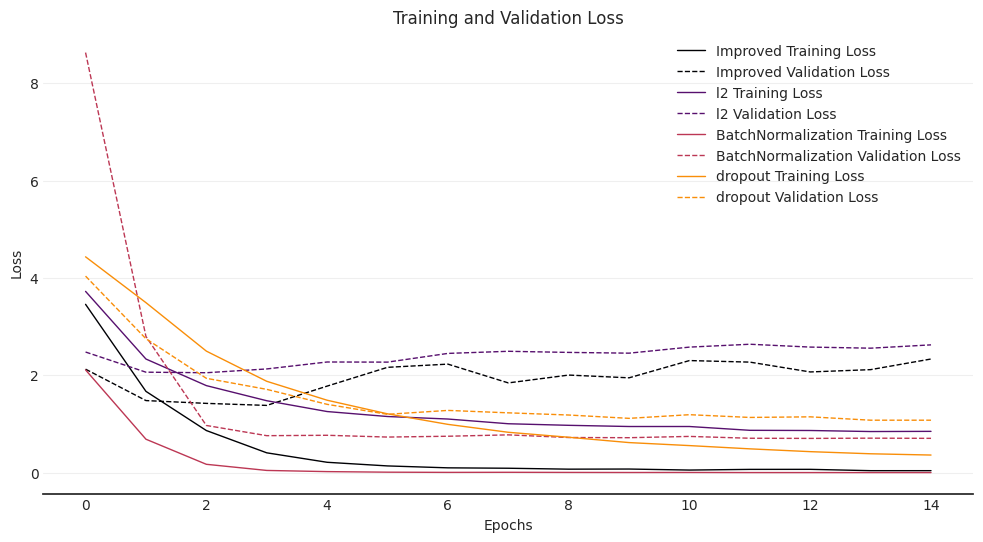

In [20]:
# Plot loss and accuracy
plot_accuracy(regularizer_histories)
plot_loss(regularizer_histories)

Les méthodes drop out et batch normalisations semblent efficace pour réduire l'overfitting et améliorer la généralisation de l'apprentissage aux données de validation. La régularisation L2 semble avoir peu d'effet, peut-être à cause d'un mauvais choix de paramètre de régularisation.

# <div style="text-align: left; background-color: #A2CBA7; font-family: Lobster;color: black; padding: 14px; line-height: 0.5;border-radius:14px; font-size: 20px"> 3.5. Réduction de l'overfitting en augmentant les données </div>

L'augmentation des données consiste à créer de nouvelles images dans le jeu de données d'entrainement à partir des images qu'il contient, en appliquant des rotations (RandomRotation) et des retournements (RandomFlip) ici.

In [21]:
# same model as improved_model with augmentation at the begining
aug_model = Sequential([
  Rescaling(1./255),
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.3),
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(2),
  Conv2D(64, 3, activation='relu'),
  MaxPooling2D(2),
  Conv2D(128, 3, activation='relu'),
  MaxPooling2D(2),
  Conv2D(128, 3, activation='relu'),
  MaxPooling2D(2),
  Flatten(),
  Dense(512, activation='relu'),
  Dense(num_classes, activation='softmax') 
])


# train and store the data
aug_histories = {}
aug_histories['Without augmentation'] = model_histories['Improved']
aug_histories['With augmentation'] = compile_and_train(aug_model, 'model/aug')

Epoch 1/15
197/197 [==============================] - 26s 119ms/step - loss: 3.6455 - accuracy: 0.1408 - val_loss: 2.7518 - val_accuracy: 0.3180
Epoch 2/15
197/197 [==============================] - 24s 119ms/step - loss: 2.2951 - accuracy: 0.3907 - val_loss: 1.8962 - val_accuracy: 0.4980
Epoch 3/15
197/197 [==============================] - 23s 117ms/step - loss: 1.7226 - accuracy: 0.5272 - val_loss: 1.6113 - val_accuracy: 0.5620
Epoch 4/15
197/197 [==============================] - 23s 117ms/step - loss: 1.4239 - accuracy: 0.6018 - val_loss: 1.4959 - val_accuracy: 0.6260
Epoch 5/15
197/197 [==============================] - 24s 118ms/step - loss: 1.2111 - accuracy: 0.6615 - val_loss: 1.2529 - val_accuracy: 0.6700
Epoch 6/15
197/197 [==============================] - 23s 117ms/step - loss: 1.0650 - accuracy: 0.6932 - val_loss: 1.1493 - val_accuracy: 0.6740
Epoch 7/15
197/197 [==============================] - 23s 117ms/step - loss: 0.9601 - accuracy: 0.7258 - val_loss: 0.9792 - val_ac

<Figure size 640x480 with 0 Axes>

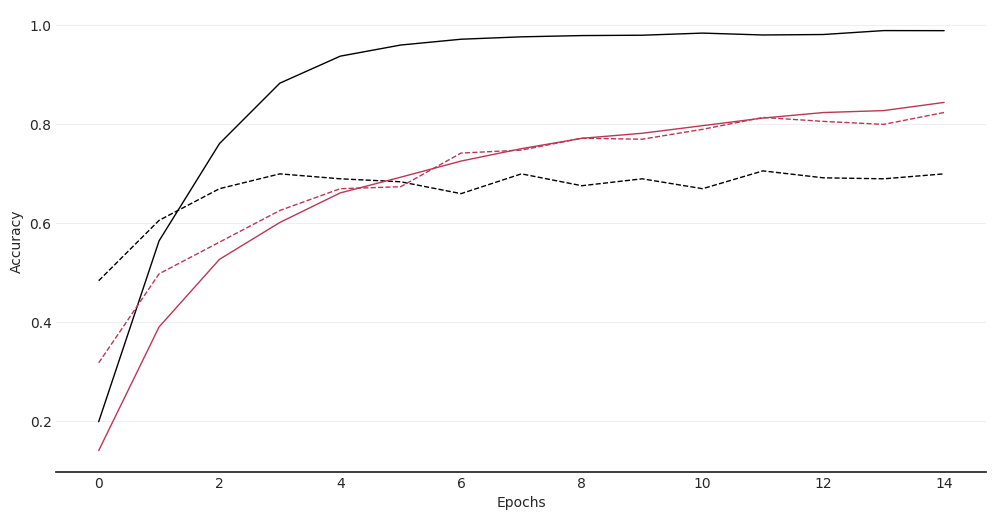

<Figure size 640x480 with 0 Axes>

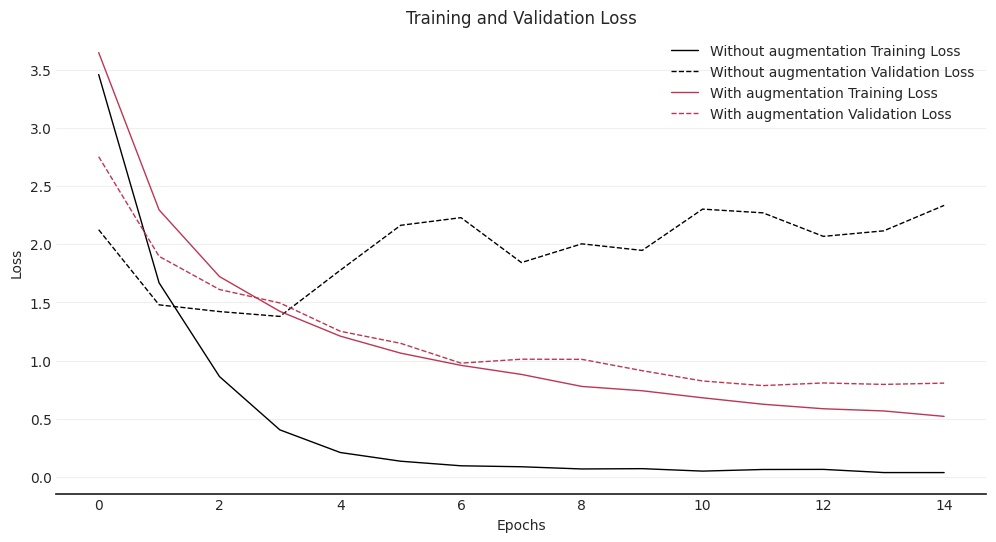

In [22]:
# Plot loss and accuracy
plot_accuracy(aug_histories)
plot_loss(aug_histories)

L'augmentation permet de nettement réduire l'overfitting.

# <div style="text-align: left; background-color: #A2CBA7; font-family: Lobster;color: black; padding: 14px; line-height: 0.5;border-radius:14px; font-size: 20px"> 3.5. Modèle final </div>

Finalement, on construit un modèle avec du dropout et de l'augmentation des données. On augmente aussi le nombre d'epoch pour laisser plus de temps au modèle pour apprendre. Un modèle encore plus complet avec des couches batch normalization ajoutées donne de moins bon résultat car l'on se retrouve en underfitting.

In [23]:
dropout_rate = 0.3

# Modèle final
final_model = Sequential([
  Rescaling(1./255),
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.3),
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(2),
  Dropout(dropout_rate),
  Conv2D(64, 3, activation='relu'),
  MaxPooling2D(2),
  Dropout(dropout_rate),
  Conv2D(128, 3, activation='relu'),
  MaxPooling2D(2),
  Dropout(dropout_rate),
  Conv2D(128, 3, activation='relu'),
  MaxPooling2D(2),
  Dropout(dropout_rate),
  Flatten(),
  Dense(512, activation='relu'),
  Dropout(dropout_rate),
  Dense(num_classes, activation='softmax') 
])


# train and store the data
model_histories['Final'] = compile_and_train(final_model, 'model/final', nb_epochs=30)

Epoch 1/30


2023-11-15 12:56:32.739122: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


197/197 [==============================] - 45s 211ms/step - loss: 4.3554 - accuracy: 0.0326 - val_loss: 4.0882 - val_accuracy: 0.0840
Epoch 2/30
197/197 [==============================] - 41s 206ms/step - loss: 3.6244 - accuracy: 0.1249 - val_loss: 3.1412 - val_accuracy: 0.2160
Epoch 3/30
197/197 [==============================] - 40s 203ms/step - loss: 3.0538 - accuracy: 0.2257 - val_loss: 2.7387 - val_accuracy: 0.3240
Epoch 4/30
197/197 [==============================] - 41s 203ms/step - loss: 2.6204 - accuracy: 0.3231 - val_loss: 2.1621 - val_accuracy: 0.4500
Epoch 5/30
197/197 [==============================] - 41s 207ms/step - loss: 2.2095 - accuracy: 0.4093 - val_loss: 1.7558 - val_accuracy: 0.5540
Epoch 6/30
197/197 [==============================] - 40s 203ms/step - loss: 1.9562 - accuracy: 0.4682 - val_loss: 1.6274 - val_accuracy: 0.5560
Epoch 7/30
197/197 [==============================] - 41s 204ms/step - loss: 1.7569 - accuracy: 0.5146 - val_loss: 1.6137 - val_accuracy: 0.5

<Figure size 640x480 with 0 Axes>

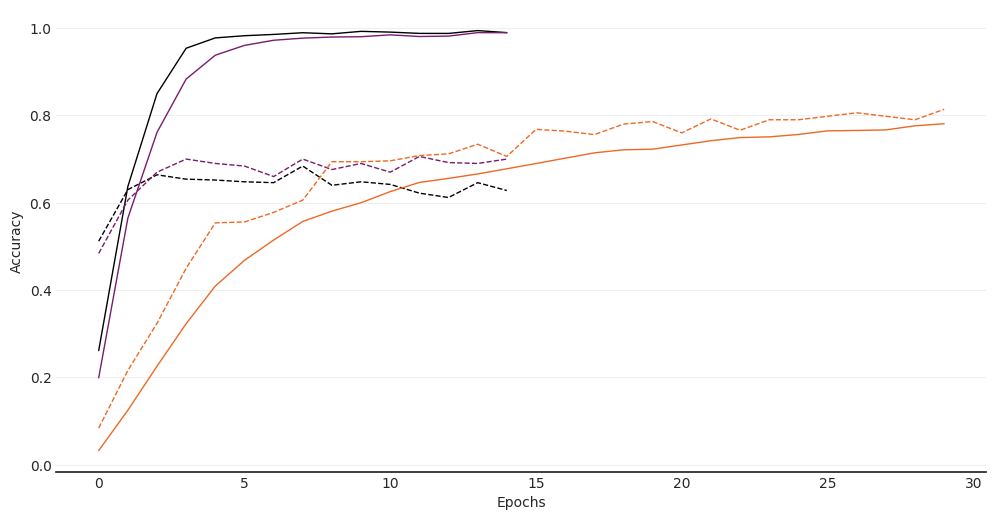

<Figure size 640x480 with 0 Axes>

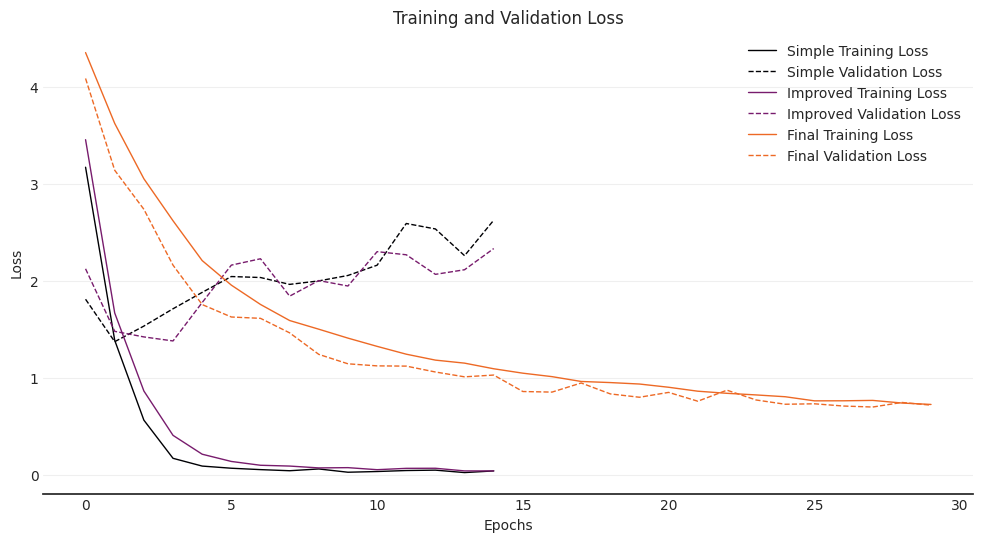

In [24]:
# Plot loss and accuracy
plot_accuracy(model_histories)
plot_loss(model_histories)

In [25]:
models = [
    ('Simple Model', simple_model),
    ('Improved Model', improved_model),
    ('Final Model', final_model)
]

results_list = []

for model_name, model in models:
    results = model.evaluate(test_ds, verbose=0)
    test_loss, test_accuracy = results
    results_list.append([model_name, test_loss, test_accuracy])

df_result = pd.DataFrame(results_list, columns=['Model', 'Test Loss', 'Test Accuracy'])

print(df_result)


            Model  Test Loss  Test Accuracy
0    Simple Model   2.367016          0.654
1  Improved Model   2.132561          0.690
2     Final Model   0.668143          0.832


Text(0.5, 1.0, 'Test Accuracy')

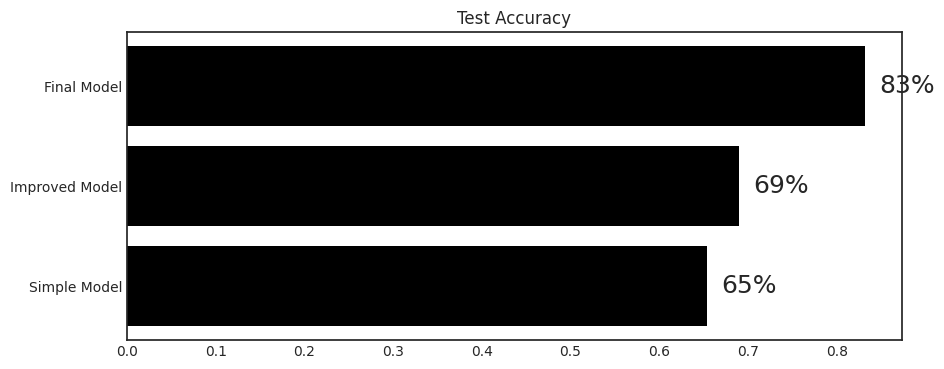

In [26]:
# plot
fig,ax = plt.subplots(figsize = (10,4))

# add bars
bars = plt.barh(df_result['Model'],df_result['Test Accuracy'],color = 'k')

# add labels
plt.bar_label(
  bars,
  labels = [f'{x:.0%}' for x in bars.datavalues],
  padding = 10,
  fontsize = 18
)

plt.title("Test Accuracy")


Finalement, par diverses techniques on a vu qu'on pouvait réduire l'overfitting. Le modèle finale donne des réponses correctes dans plus de 80% des cas sur les données de test, ce qui est assez bon mais améliorable en utilisant du transfert learning.

# <div style="text-align: center; background-color: #87CEEB; font-family: Lobster;color: black; padding: 14px; line-height: 1;border-radius:14px"> 4. Modèle avec transfert learning </div>

Dans cette partie on va faire du transfer learning sur 2 modèles MobileNet et ResNet50. Les deux utilisent ont des architectures différentes et ont été conçu pour répondre à des problèmes différents.
Dans un premier temps on entraine les couches de classifications puis on entraine l'ensemble du modèle (étape de fine-tuning).

Nos deux modèles ont été pré-entrainé sur la base de données de imagenet.

On utilise le même protocole pour les 2 modèles. On commence par importer le modèle en bloquant son apprentissage, on rajoute des couches de classification d'image avec à la fin une couche de neurones dites 'dense' pour classifier les images. On entraine le modèle (seul les couches de classifications seront entrainé) et on évalue sa capacité de prédiction. Puis on effectue du fine-tuning. On va permettre à l'entiereté de notre modèle de s'entrainer sur nos données mais avec un learning rate plus bas. L'objectif de cette étape est d'augmenter légerement notre capacité de prédiction sans gagner en surajustement.

In [27]:
#On inclus dans notre modèle une couche qui créer des images modifié pour l'entrainement
data_augmentation = keras.Sequential(
    [
    layers.experimental.preprocessing.RandomFlip("horizontal"), #On effectue plusieurs transformations dont, tourner les images de 180°,
  layers.experimental.preprocessing.RandomRotation(0.13), #des rotations sur nos images
  layers.experimental.preprocessing.RandomZoom(0.12), #des zooms 
  layers.experimental.preprocessing.RandomContrast(0.10),# et on modifie les contrastes
    ]
) #L'objectif étant de limiter l'overfitting  et donc d'améliorer ça capacité de prédiction

In [28]:
#pour simplifier choix entre modèle on créer une fonction qui nous permet de récupérer le modèle d'intéret et sa fonction de traitement d'image

def choimod(modname):
    if modname == "resnet":
        preprocess = tf.keras.applications.resnet.preprocess_input
        base_model1= tf.keras.applications.ResNet50(
            include_top=False,
            input_shape=(img_height, img_width,3),
            pooling='avg',#classes=100,
            weights='imagenet',
        classifier_activation='softmax')
        
    if modname == "MobileNet":
        preprocess=tf.keras.applications.mobilenet.preprocess_input
        base_model1=tf.keras.applications.mobilenet.MobileNet(
        input_shape=(img_height, img_width,3),
        include_top=False,
        weights='imagenet',#classes=100,
        classifier_activation='softmax',
)
        
    
    return preprocess, base_model1

# <div style="text-align: left; background-color: #A2CBA7; font-family: Lobster;color: black; padding: 14px; line-height: 0.5;border-radius:14px; font-size: 20px"> 4.1. MobileNet: Création et entrainement</div>

Le premier modèle que l'on test est MobileNet. C'est un CNN adapté au problème de classification d'image qui utilise de la depthwise separable convolutions lui permettant de diminuer le temps de calcul.

In [29]:
#On commence par s'intéresser à MobileNet
preprocess, base_model1 = choimod("MobileNet")


base_model1.trainable=False #on gèle les couches du modèle que l'on importe

inputs = Input(shape=(img_height, img_width, 3)) #format des inputs
x = data_augmentation(inputs)  #on rajoute des données avec la couche défini précedement


x = preprocess(inputs) #on adapte nos input au besoins de notre modèle
        
x = base_model1(x)  #On applique notre modèle 

x = Flatten()(x) #Permet de transformer notre sorties en un vecteur
x = Dense(512, activation='relu')(x) 
x = layers.Dropout(rate = 0.5)(x) #Ajoute un taux d'inactivation des neurones de manières aléatoire pour limiter l'overfitting
outputs=Dense(100, activation='softmax')(x)   #Permet de classer nos prédictions    
        
model1 = keras.Model(inputs, outputs)


model1.summary() #Vérification de notre modèle

17225924/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 244, 244, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 244, 244, 3)      0         
 a)                                                              
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 50176)             0      

In [30]:
#On compile puis fait tourner le modèle 
model1.compile(optimizer=Adam(learning_rate=0.0001), #Algorithme du gradient stochastique
             loss='sparse_categorical_crossentropy', #Loss function
             metrics=['accuracy'])


history = model1.fit(
    train_ds,
    steps_per_epoch=len(train_ds),
    validation_data=validation_ds,
    validation_steps=len(validation_ds),
    epochs=15,
    callbacks=[
        EarlyStopping(monitor = "val_loss", #Permet d'arreter le modèle quand on ne gagne plus de précision
                               patience = 3, # On arrête l'entrainement quand on ne gagne plus de précision
                               restore_best_weights = True), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)
model1.save_weights('./checkpoints/my_checkpoint')

Epoch 1/15
197/197 [==============================] - 23s 100ms/step - loss: 2.9656 - accuracy: 0.3394 - val_loss: 0.8073 - val_accuracy: 0.8180 - lr: 1.0000e-04
Epoch 2/15
197/197 [==============================] - 18s 92ms/step - loss: 0.9664 - accuracy: 0.7469 - val_loss: 0.4561 - val_accuracy: 0.8860 - lr: 1.0000e-04
Epoch 3/15
197/197 [==============================] - 18s 91ms/step - loss: 0.4371 - accuracy: 0.8791 - val_loss: 0.3910 - val_accuracy: 0.9020 - lr: 1.0000e-04
Epoch 4/15
197/197 [==============================] - 18s 91ms/step - loss: 0.2807 - accuracy: 0.9179 - val_loss: 0.3553 - val_accuracy: 0.9120 - lr: 1.0000e-04
Epoch 5/15
197/197 [==============================] - 18s 91ms/step - loss: 0.1883 - accuracy: 0.9472 - val_loss: 0.3226 - val_accuracy: 0.9180 - lr: 1.0000e-04
Epoch 6/15
197/197 [==============================] - 19s 92ms/step - loss: 0.1361 - accuracy: 0.9603 - val_loss: 0.3098 - val_accuracy: 0.9260 - lr: 1.0000e-04
Epoch 7/15
197/197 [=============

<Figure size 640x480 with 0 Axes>

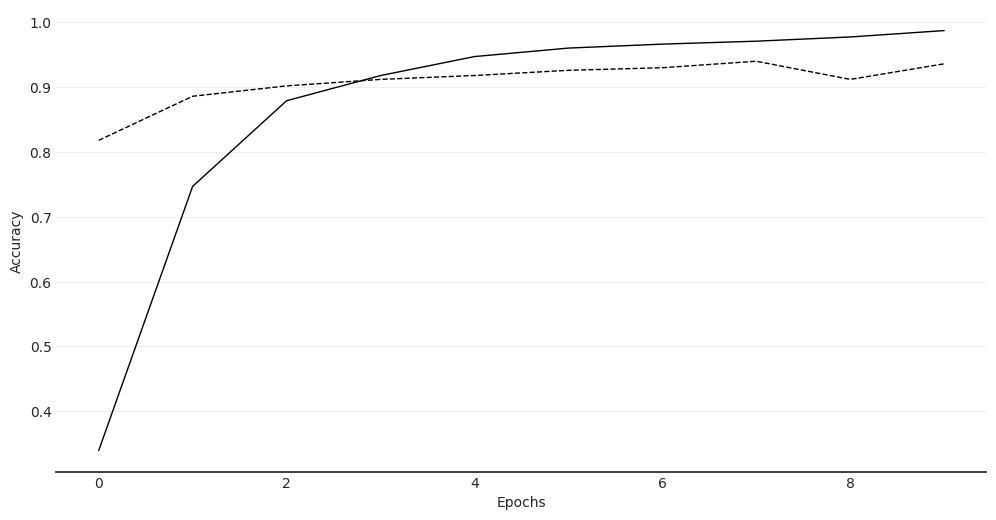

<Figure size 640x480 with 0 Axes>

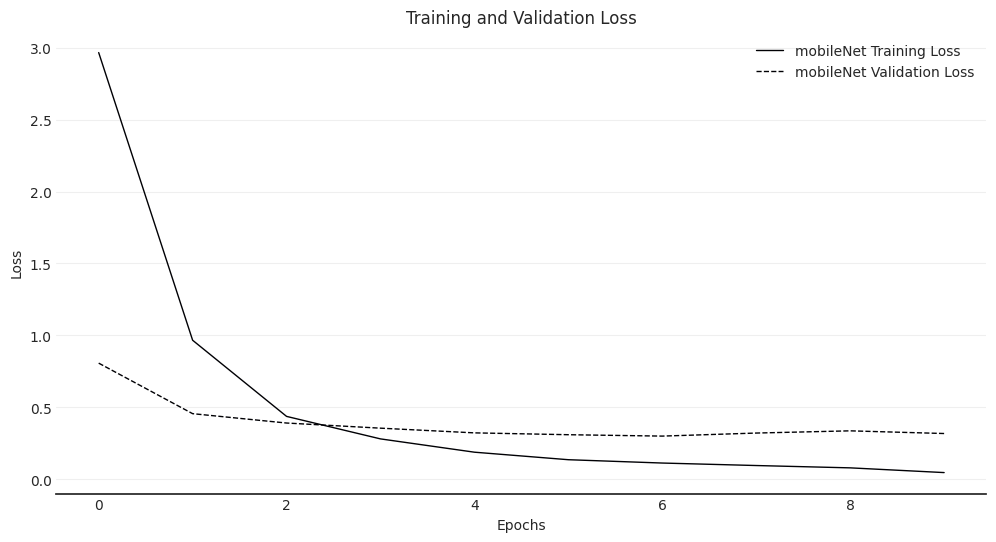

In [31]:
transfert_histories = {}
transfert_histories["mobileNet"] = history
# Plot loss and accuracy
plot_accuracy(transfert_histories)
plot_loss(transfert_histories)

# <div style="text-align: left; background-color: #A2CBA7; font-family: Lobster;color: black; padding: 14px; line-height: 0.5;border-radius:14px; font-size: 20px"> 4.2. MobileNet: Fine-tuning</div>

In [32]:
#On a effectuer une étape de fine tuning pour améliorer nos prédections

model1.trainable = True  #on permet aux couches du modèle de s'entrainer


model1.summary() #On verifie que les couches sont entrainables

model1.compile(optimizer=Adam(0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#On recompile notre modèle mais cette fois on utilise un taux d'apprentissage plus faible 


history = model1.fit(
    train_ds,
    steps_per_epoch=len(train_ds),
    validation_data=validation_ds,
    validation_steps=len(validation_ds),
    epochs=45,#On met un nombre important d'epoch qui ne sera pas atteint grace à la fonction Earlystoping
    callbacks=[
        EarlyStopping(monitor = "val_loss", 
                               patience = 3,
                               restore_best_weights = True), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)
model1.save_weights('./checkpoints/my_checkpoint')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 244, 244, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 244, 244, 3)      0         
 a)                                                              
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 50176)             0         
                                                             

<Figure size 640x480 with 0 Axes>

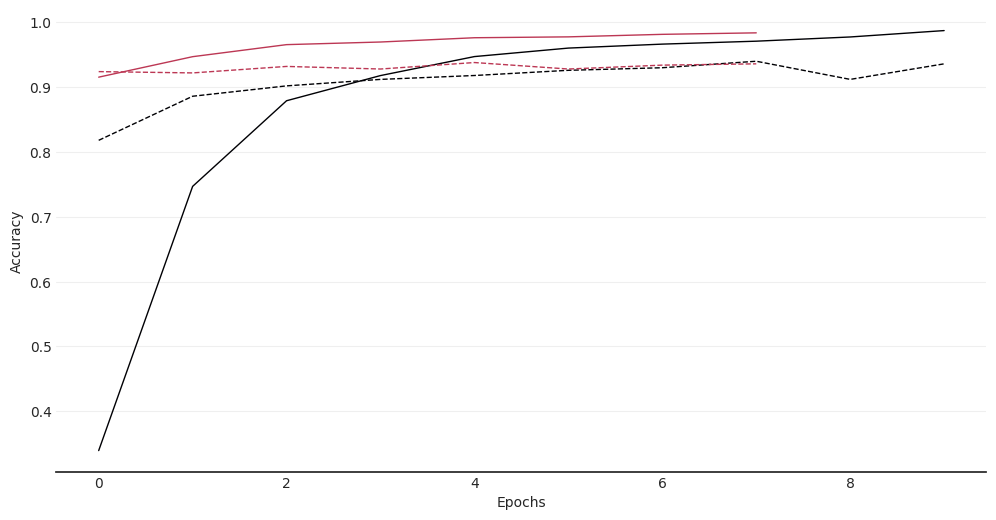

<Figure size 640x480 with 0 Axes>

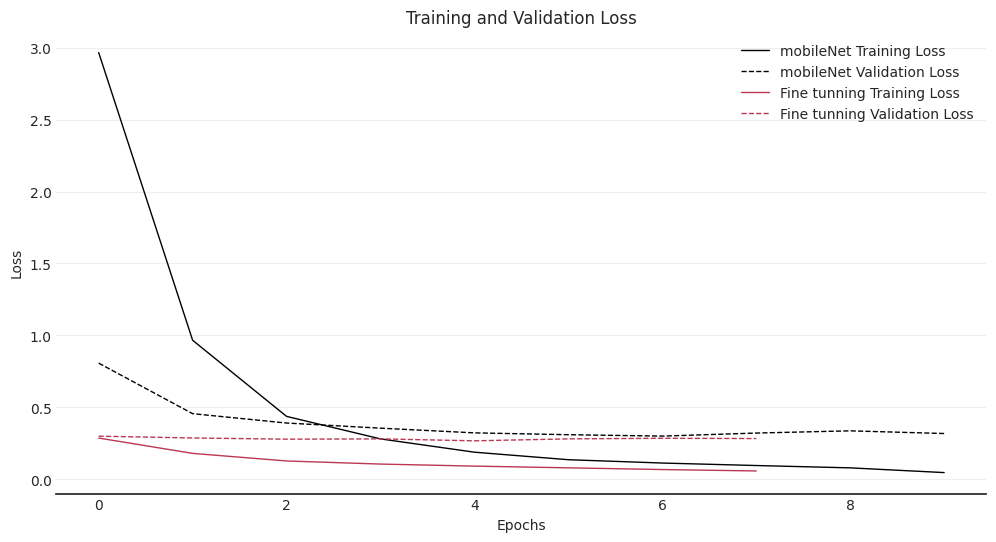

In [33]:
transfert_histories["Fine tunning"] = history
# Plot loss and accuracy
plot_accuracy(transfert_histories)
plot_loss(transfert_histories)

# <div style="text-align: left; background-color: #A2CBA7; font-family: Lobster;color: black; padding: 14px; line-height: 0.5;border-radius:14px; font-size: 20px"> 4.3. MobileNet: Prédiction</div>

A présent, on teste les capacités prédictives du modèle sur des données test, qu'il n'a jamais rencontré.

In [34]:
df = pd.read_csv('/kaggle/input/butterfly-images40-species/butterflies and moths.csv')  
test_df = df.loc[df['data set'] == 'test']
solution=test_df['labels']
class_names = train_ds.class_names


test_dataset = image_dataset_from_directory('/kaggle/input/butterfly-images40-species/test',
                                             image_size= (img_height, img_width),
                                           shuffle=False)
test_ds = image_dataset_from_directory(
  test_dir,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
shuffle=False)


test_images, test_labels = tuple(zip(*test_ds))
######################################

predictions = model1.predict(test_ds)
score = tf.nn.softmax(predictions)
result = model1.evaluate(test_dataset)
print("Test loss, test accuracy:", result)


from sklearn.metrics import classification_report, f1_score, confusion_matrix

y_test = np.concatenate(test_labels) 
y_pred = np.array([np.argmax(s) for s in score])

tabfinale = classification_report(y_test, y_pred, target_names=class_names)

print(tabfinale)


# predict
y_pred = []
errors = 0
count = 0
preds = model1.predict(test_ds)


#calcul de la précision globale du modèle
for i, p in enumerate(predictions):
    count += 1
    index = np.argmax(p)
    y_pred.append(class_names[index])  
    if class_names[index] != solution.iloc[i]:
        errors += 1

print(count)
print(errors)

print("Accuracy",(count-errors)* 100/count)

Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
16/16 [==============================] - 1s 64ms/step - loss: 0.1704 - accuracy: 0.9560
Test loss, test accuracy: [0.17037014663219452, 0.9559999704360962]
                           precision    recall  f1-score   support

                   ADONIS       1.00      1.00      1.00         5
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         5
           AMERICAN SNOOT       1.00      0.80      0.89         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       1.00      0.80      0.89         5
     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
                    ATALA       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
 BANDED ORANGE HELICONIAN       0.83      1.00      0.91         5
           BANDED PEACOCK       1.00      1.00      1.00         5
        BANDED TIGER M

Le résultat est exprimé sous forme d'un rapport de classification indiquant trois scores.
La précision, qui est égale au nombre de vrais positifs divisé par le nombre de vrais positifs plus le nombre de faux positifs. C'est un indicateur de la capacité du modèle à ne pas identifier un individu comme une espèce qu'il n'est pas.
Le recall, qui est égal au nombre de vrais positifs divisé par le nombre de vrais positifs plus le nombre de faux négatif. Cela traduit la capacité du modèle à identifier toutes les images d'une espèce présente dans le jeu de données.
Le f1-score, qui est une moyenne harmonique des deux précédents scores.
On peut voir que la précision globale du modèle sur les données test est de 96%. C'est plutôt satisfants.

Une autre façon de représenter ces résultats est sous la forme d'une matrice de confusion. Elle a l'avantage de montrer quelles espèces sont confondues avec quelles espèces. Mais lorsque qu'il y a 100 espèces, ce n'est pas très pratique à lire.

In [35]:
y_test = np.concatenate(test_labels)
y_pred = np.array([np.argmax(s) for s in score])
cm = confusion_matrix(y_test, y_pred)

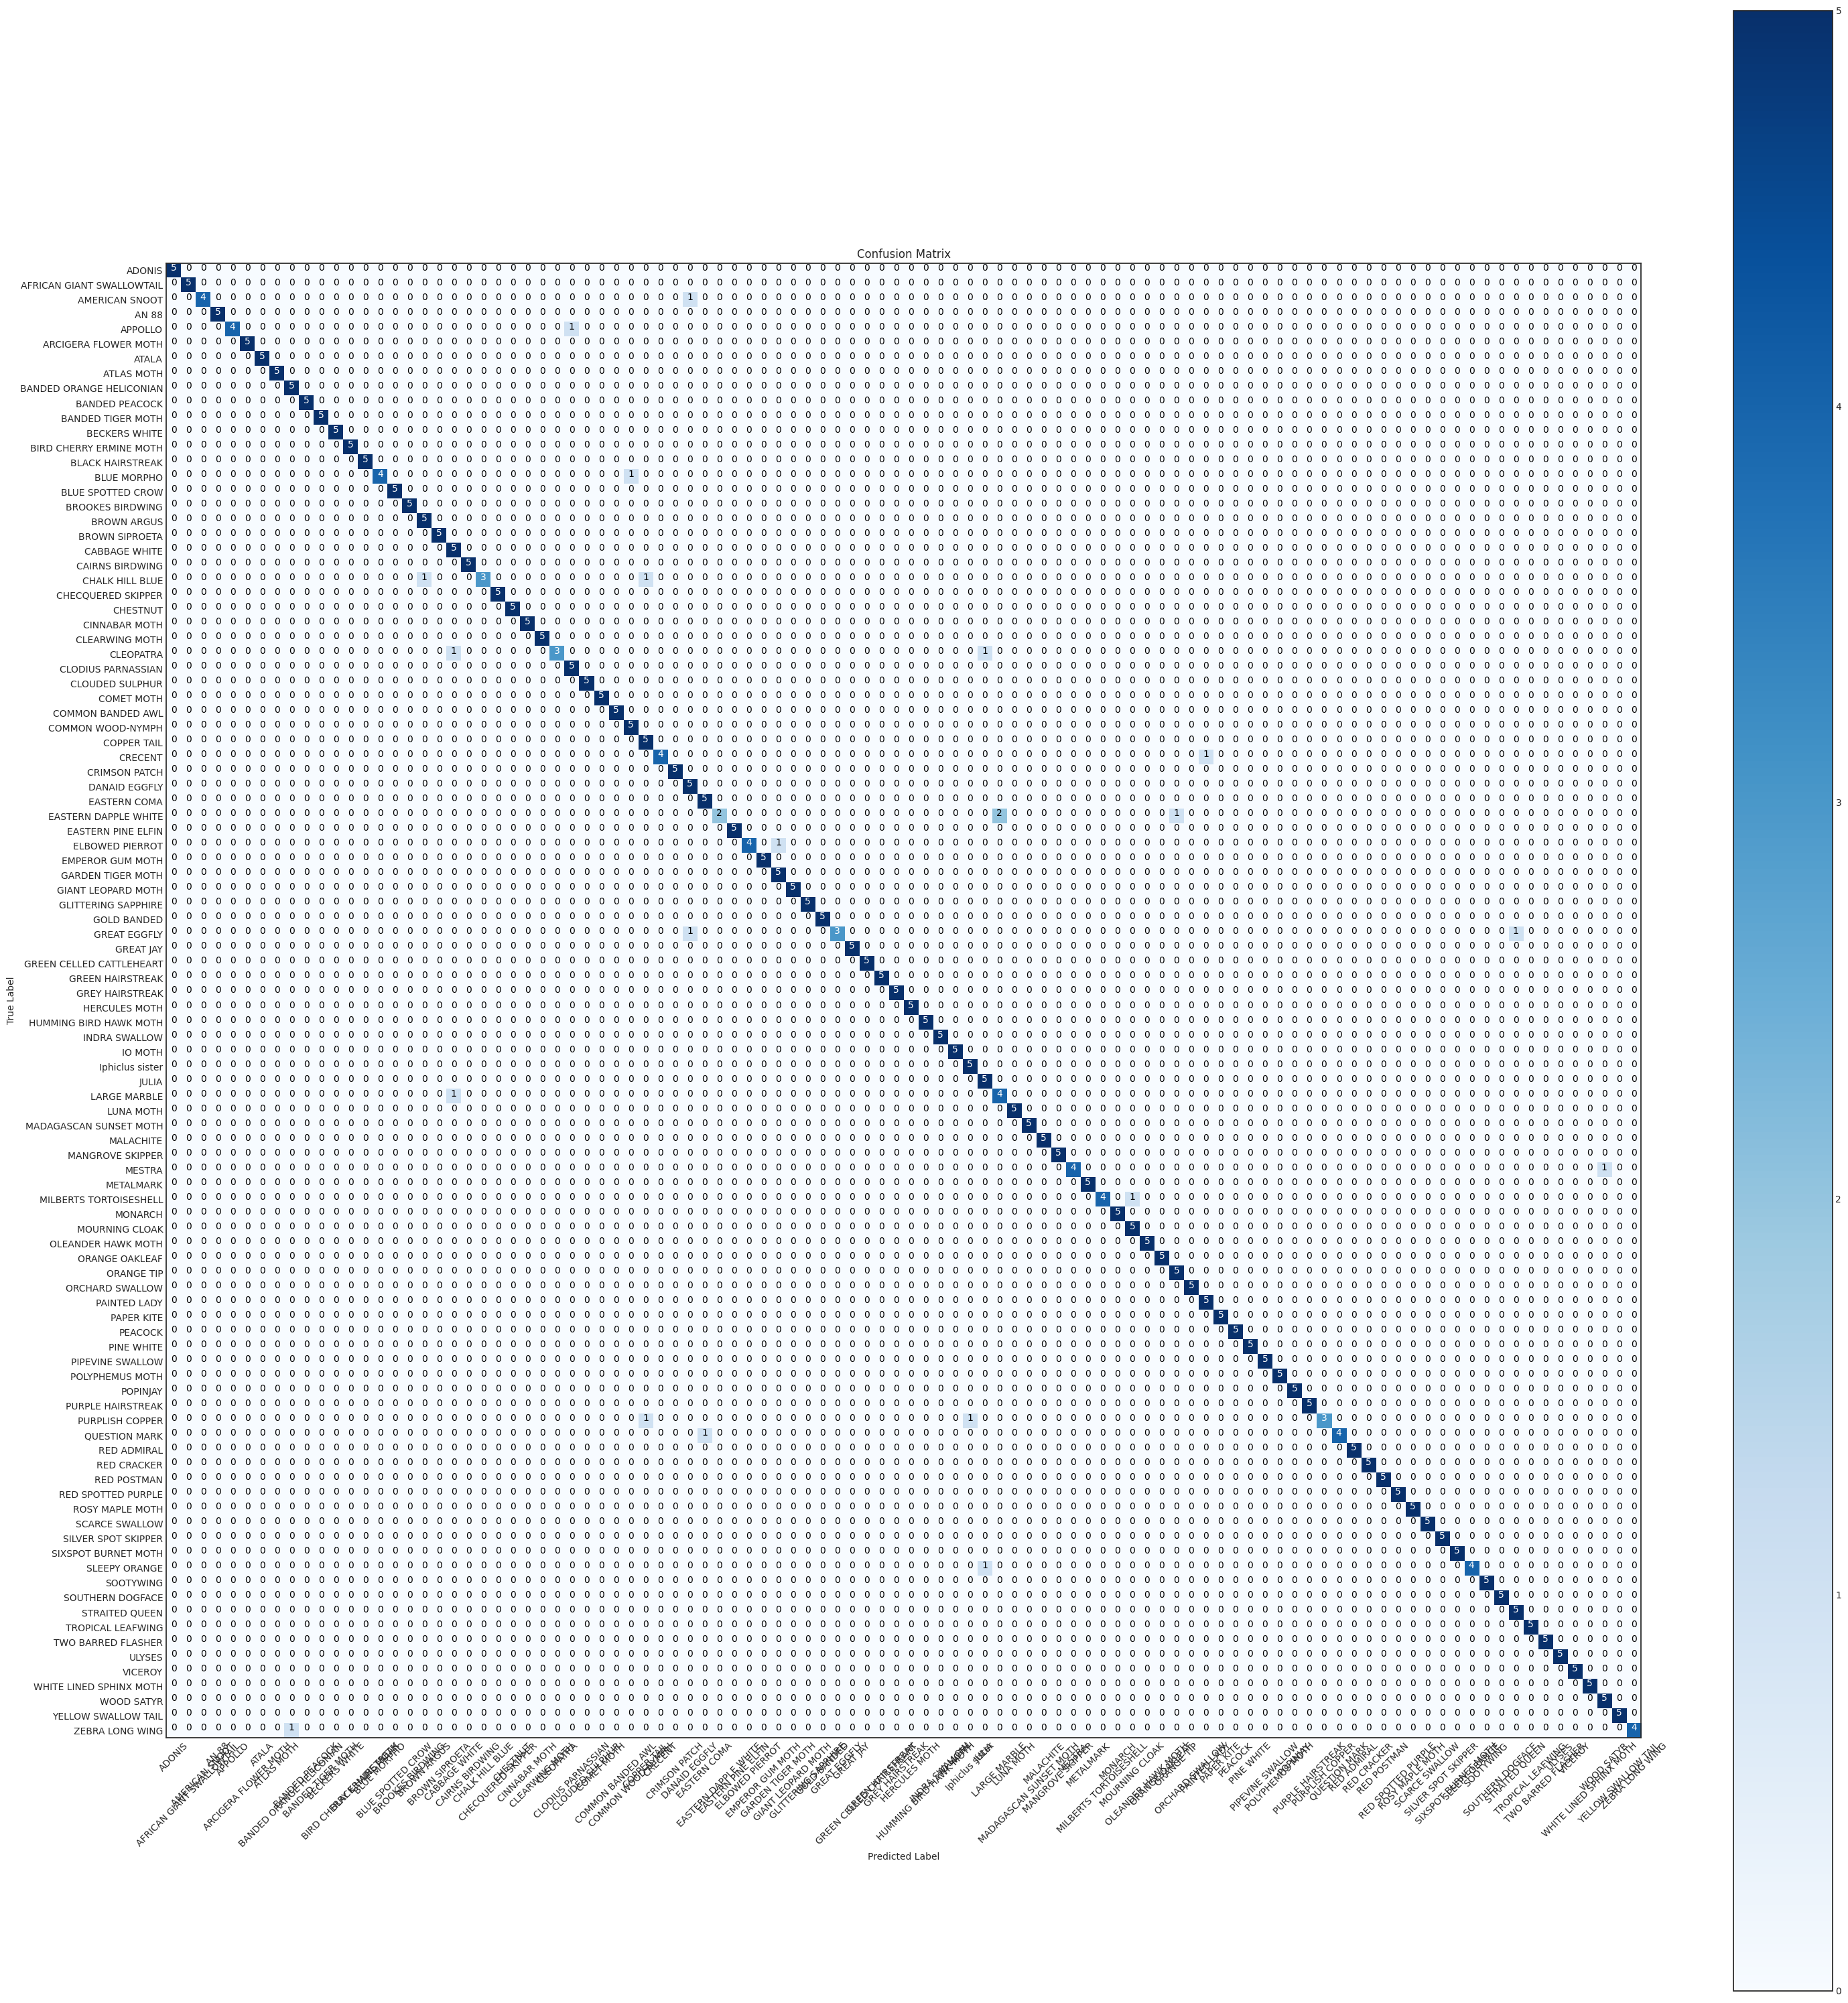

Classification error:  4.4 %


In [36]:
import itertools

plt.figure(figsize= (30, 30))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation= 45)
plt.yticks(tick_marks, class_names)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()
print("Classification error: ", np.round((1-np.sum(np.diag(cm))/np.shape(test_df)[0])*100,2),"%")

On note que l'erreur de classification est de 4%,c'est cohérent avec le 96% de précision.

On peut aussi identifier quelles sont les espèces pour lesquelles le modèle se trompe (basé sur le f1-score), et représenter ces espèces.

In [37]:
tabfinale = classification_report(y_test, y_pred, target_names=class_names,output_dict=True)
df_classification_report = pd.DataFrame(tabfinale).transpose()
df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=True)
#df_classification_report.head(15)
print(df_classification_report)
#print(df_classification_report.shape[0])
list_labels = []
for i in range(0,101):
    if(df_classification_report['f1-score'][i]!=1):
        list_labels.append(df_classification_report.index.tolist()[i])
list_show = list_labels[0:8]

                        precision  recall  f1-score  support
EASTERN DAPPLE WHITE     1.000000     0.4  0.571429      5.0
LARGE MARBLE             0.666667     0.8  0.727273      5.0
CLEOPATRA                1.000000     0.6  0.750000      5.0
PURPLISH COPPER          1.000000     0.6  0.750000      5.0
CHALK HILL BLUE          1.000000     0.6  0.750000      5.0
...                           ...     ...       ...      ...
EASTERN PINE ELFIN       1.000000     1.0  1.000000      5.0
CRIMSON PATCH            1.000000     1.0  1.000000      5.0
COMMON BANDED AWL        1.000000     1.0  1.000000      5.0
METALMARK                1.000000     1.0  1.000000      5.0
HUMMING BIRD HAWK MOTH   1.000000     1.0  1.000000      5.0

[103 rows x 4 columns]


Attention, ces images ne sont pas forcément celles qui ont été mal identifiées, elles représentent juste les espèces mal identifiées.

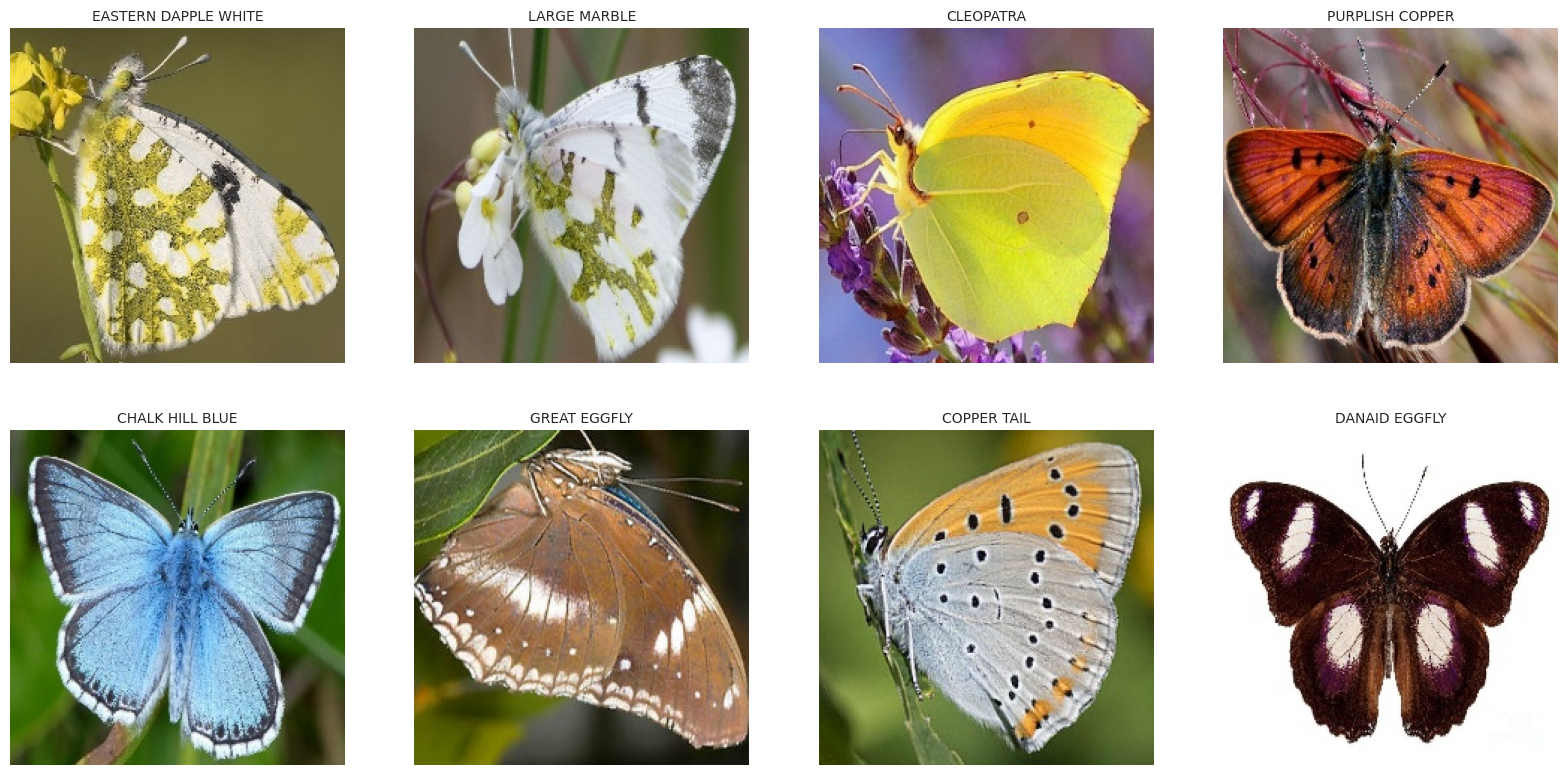

In [38]:
from PIL import Image
plt.figure(figsize=(20,20))
for i in range(0,len(list_show)):
    plt.subplot(4,4,i+1)
    image_path = "/kaggle/input/butterfly-images40-species/test/"+list_show[i]+"/1.jpg"
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(list_show[i], fontsize=10)
    plt.axis('off')
plt.show()

# <div style="text-align: left; background-color: #A2CBA7; font-family: Lobster;color: black; padding: 14px; line-height: 0.5;border-radius:14px; font-size: 20px"> 4.4. ResNet: Création et entrainement </div>

ResNet50 est un CNN de la famille des résaux de neurones résiduels. Ils sont particulièrement interessant car ils permettent de faire des résaux de neurones très profonds sans perdre en efficacité. En effet plus un résaux de neurones est profonds plus sa précision ça précision augmente mais à partir d'un stade l'apprentissage est plus complexe. 

94765736/94765736 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 244, 244, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 244, 244, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_8 (Flatten)         (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 512)               10490

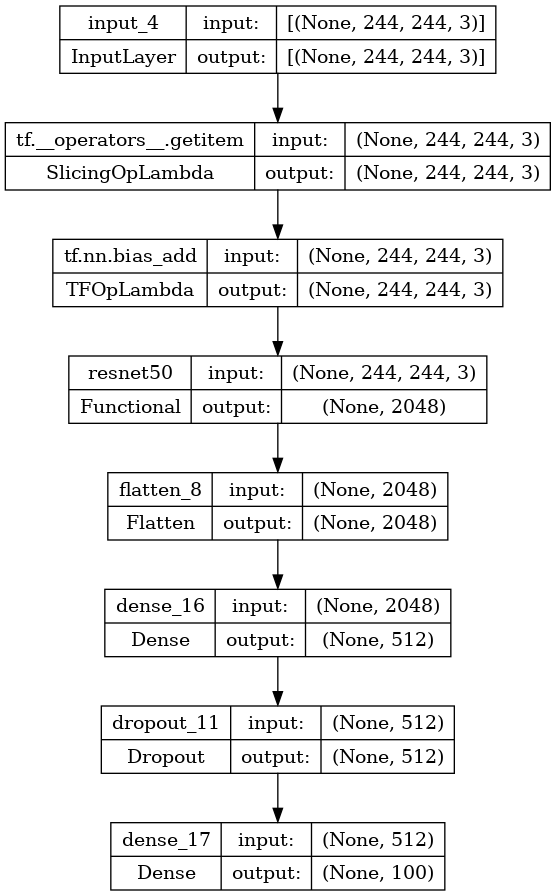

In [39]:
preprocess, base_model2 = choimod("resnet")


base_model2.trainable=False 

inputs = Input(shape=(img_height, img_width, 3)) 
x = data_augmentation(inputs)  


x = preprocess(inputs) 
        
x = base_model2(x)  

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = layers.Dropout(rate = 0.5)(x)
outputs=Dense(100, activation='softmax')(x)       
        
model2 = keras.Model(inputs, outputs)



model2.summary()
#base_model1.summary()
tf.keras.utils.plot_model(model2, show_shapes=True)


In [40]:
model2.compile(optimizer=Adam(learning_rate=0.001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])



history2 = model2.fit(
    train_ds,
    steps_per_epoch=len(train_ds),
    validation_data=validation_ds,
    validation_steps=len(validation_ds),
    epochs=15,
    callbacks=[
        EarlyStopping(monitor = "val_loss",
                               patience = 3,
                               restore_best_weights = True), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)


Epoch 1/15
197/197 [==============================] - 57s 254ms/step - loss: 1.8547 - accuracy: 0.5542 - val_loss: 0.4801 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 2/15
197/197 [==============================] - 45s 226ms/step - loss: 0.6458 - accuracy: 0.8186 - val_loss: 0.3005 - val_accuracy: 0.9180 - lr: 0.0010
Epoch 3/15
197/197 [==============================] - 45s 227ms/step - loss: 0.4505 - accuracy: 0.8708 - val_loss: 0.2507 - val_accuracy: 0.9220 - lr: 0.0010
Epoch 4/15
197/197 [==============================] - 45s 226ms/step - loss: 0.3558 - accuracy: 0.8968 - val_loss: 0.2308 - val_accuracy: 0.9360 - lr: 0.0010
Epoch 5/15
197/197 [==============================] - 45s 227ms/step - loss: 0.3061 - accuracy: 0.9073 - val_loss: 0.2068 - val_accuracy: 0.9360 - lr: 0.0010
Epoch 6/15
197/197 [==============================] - 45s 227ms/step - loss: 0.2554 - accuracy: 0.9203 - val_loss: 0.2010 - val_accuracy: 0.9420 - lr: 0.0010
Epoch 7/15
197/197 [==============================] 

<Figure size 640x480 with 0 Axes>

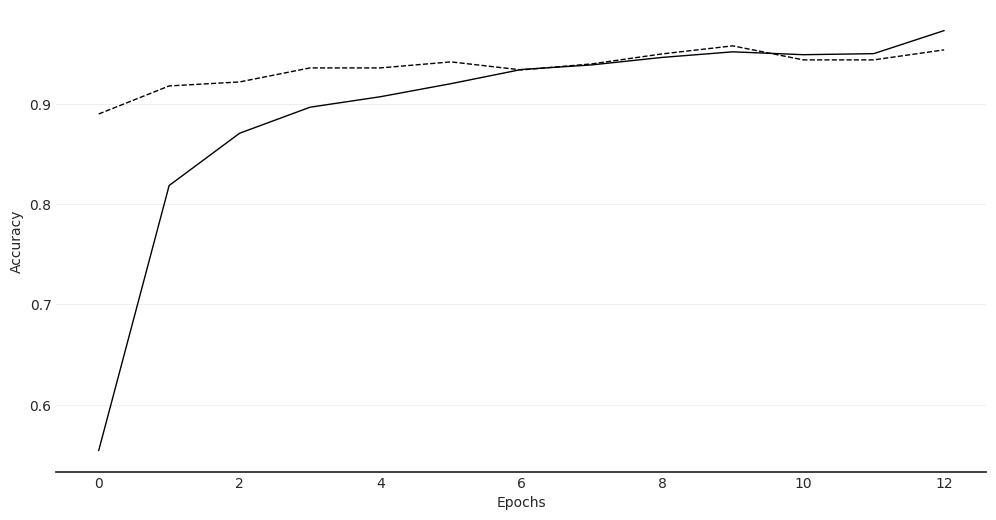

<Figure size 640x480 with 0 Axes>

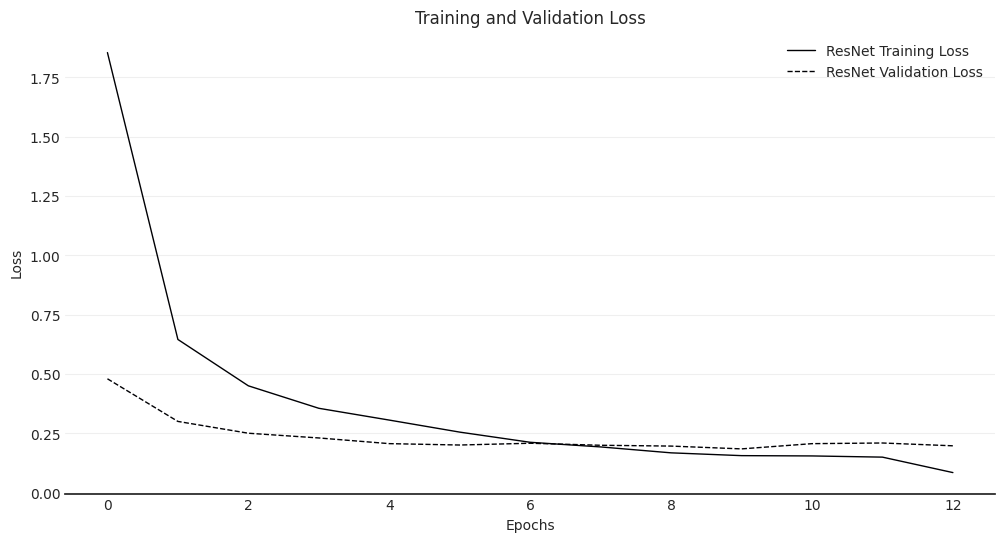

In [41]:
transfert_histories2 = {}
transfert_histories2["ResNet"] = history2
# Plot loss and accuracy
plot_accuracy(transfert_histories2)
plot_loss(transfert_histories2)

# <div style="text-align: left; background-color: #A2CBA7; font-family: Lobster;color: black; padding: 14px; line-height: 0.5;border-radius:14px; font-size: 20px"> 4.5. ResNet: Fine-tuning </div>

In [42]:
#finetuning
#base_tune = model1.layers[4]

#fine = 100 #couches qui ne seront pas entraine dans le model
model2.trainable = True  # on unfreeze les couches de notre modele

#for layer in base_tune.layers[:fine]:

model2.summary() #On verifie que les couches sont entrainables

model2.compile(optimizer=Adam(0.0001),#on entraine notre modèle avec un learning rate très faible pour limiter l'overfitting
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])



history = model2.fit(
    train_ds,
    steps_per_epoch=len(train_ds),
    validation_data=validation_ds,
    validation_steps=len(validation_ds),
    epochs=45,
    callbacks=[
        EarlyStopping(monitor = "val_loss", 
                               patience = 3,
                               restore_best_weights = True), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 244, 244, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 244, 244, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_8 (Flatten)         (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 512)               1049088   
                                                           

<Figure size 640x480 with 0 Axes>

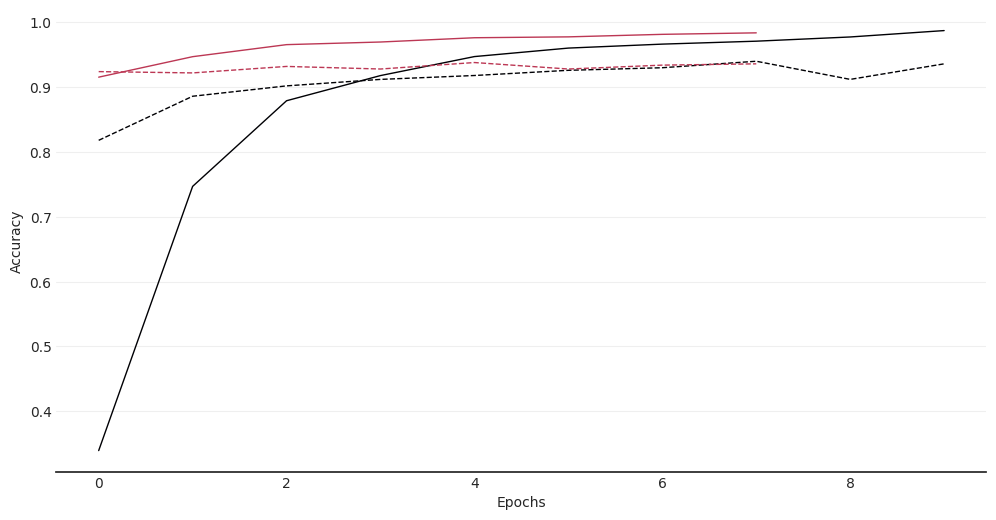

<Figure size 640x480 with 0 Axes>

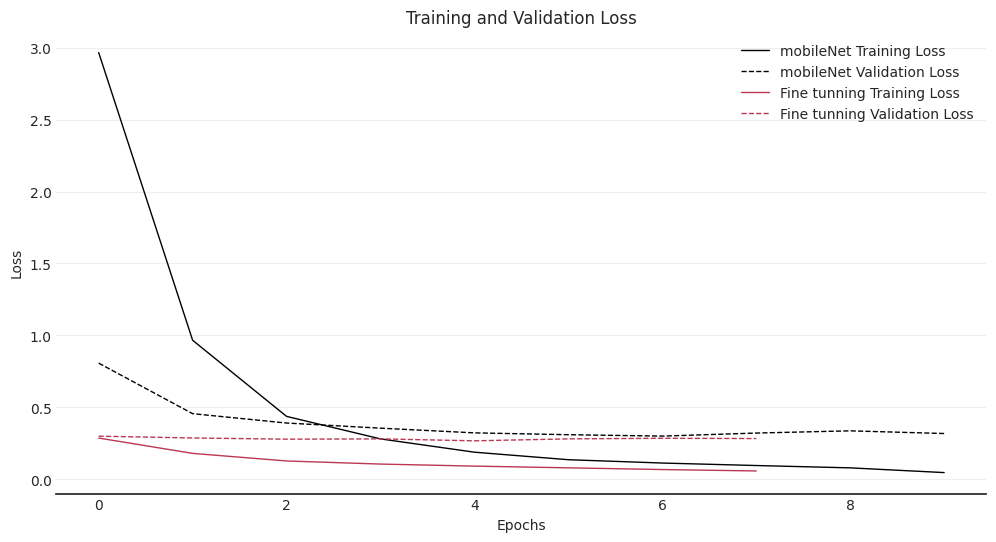

In [43]:
transfert_histories2["Fine tunning"] = history
# Plot loss and accuracy
plot_accuracy(transfert_histories)
plot_loss(transfert_histories)

# <div style="text-align: left; background-color: #A2CBA7; font-family: Lobster;color: black; padding: 14px; line-height: 0.5;border-radius:14px; font-size: 20px"> 4.6. ResNet: Prédiction </div>

On peut maintenant faire comme le modèle crée à partir de MobileNet et évaluer la performance du modèle sur des images qu'il n'a jamais vu.

In [44]:

predictions = model2.predict(test_ds)
score = tf.nn.softmax(predictions)
result = model2.evaluate(test_ds)
print("Test loss, test accuracy:", result)


from sklearn.metrics import classification_report, confusion_matrix

y_test = np.concatenate(test_labels) 
y_pred = np.array([np.argmax(s) for s in score])

tabfinale = classification_report(y_test, y_pred, target_names=class_names)

print(tabfinale)


# predict
y_pred = []
errors = 0
count = 0
preds = model2.predict(test_ds)



for i, p in enumerate(predictions):
    count += 1
    index = np.argmax(p)
    y_pred.append(class_names[index])  
    if class_names[index] != solution.iloc[i]:
        errors += 1

print(count)
print(errors)

print("Accuracy",(count-errors)* 100/count)

8/8 [==============================] - 2s 207ms/step - loss: 0.1178 - accuracy: 0.9720
Test loss, test accuracy: [0.11779890954494476, 0.972000002861023]
                           precision    recall  f1-score   support

                   ADONIS       1.00      1.00      1.00         5
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         5
           AMERICAN SNOOT       1.00      0.80      0.89         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       1.00      1.00      1.00         5
     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
                    ATALA       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
 BANDED ORANGE HELICONIAN       1.00      1.00      1.00         5
           BANDED PEACOCK       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
            BECKERS WHITE       1.00     

La précision globale du modèle est de 98%, c'est mieux que le précédent modèle.

In [45]:
y_test = np.concatenate(test_labels)
y_pred = np.array([np.argmax(s) for s in score])
cm = confusion_matrix(y_test, y_pred)

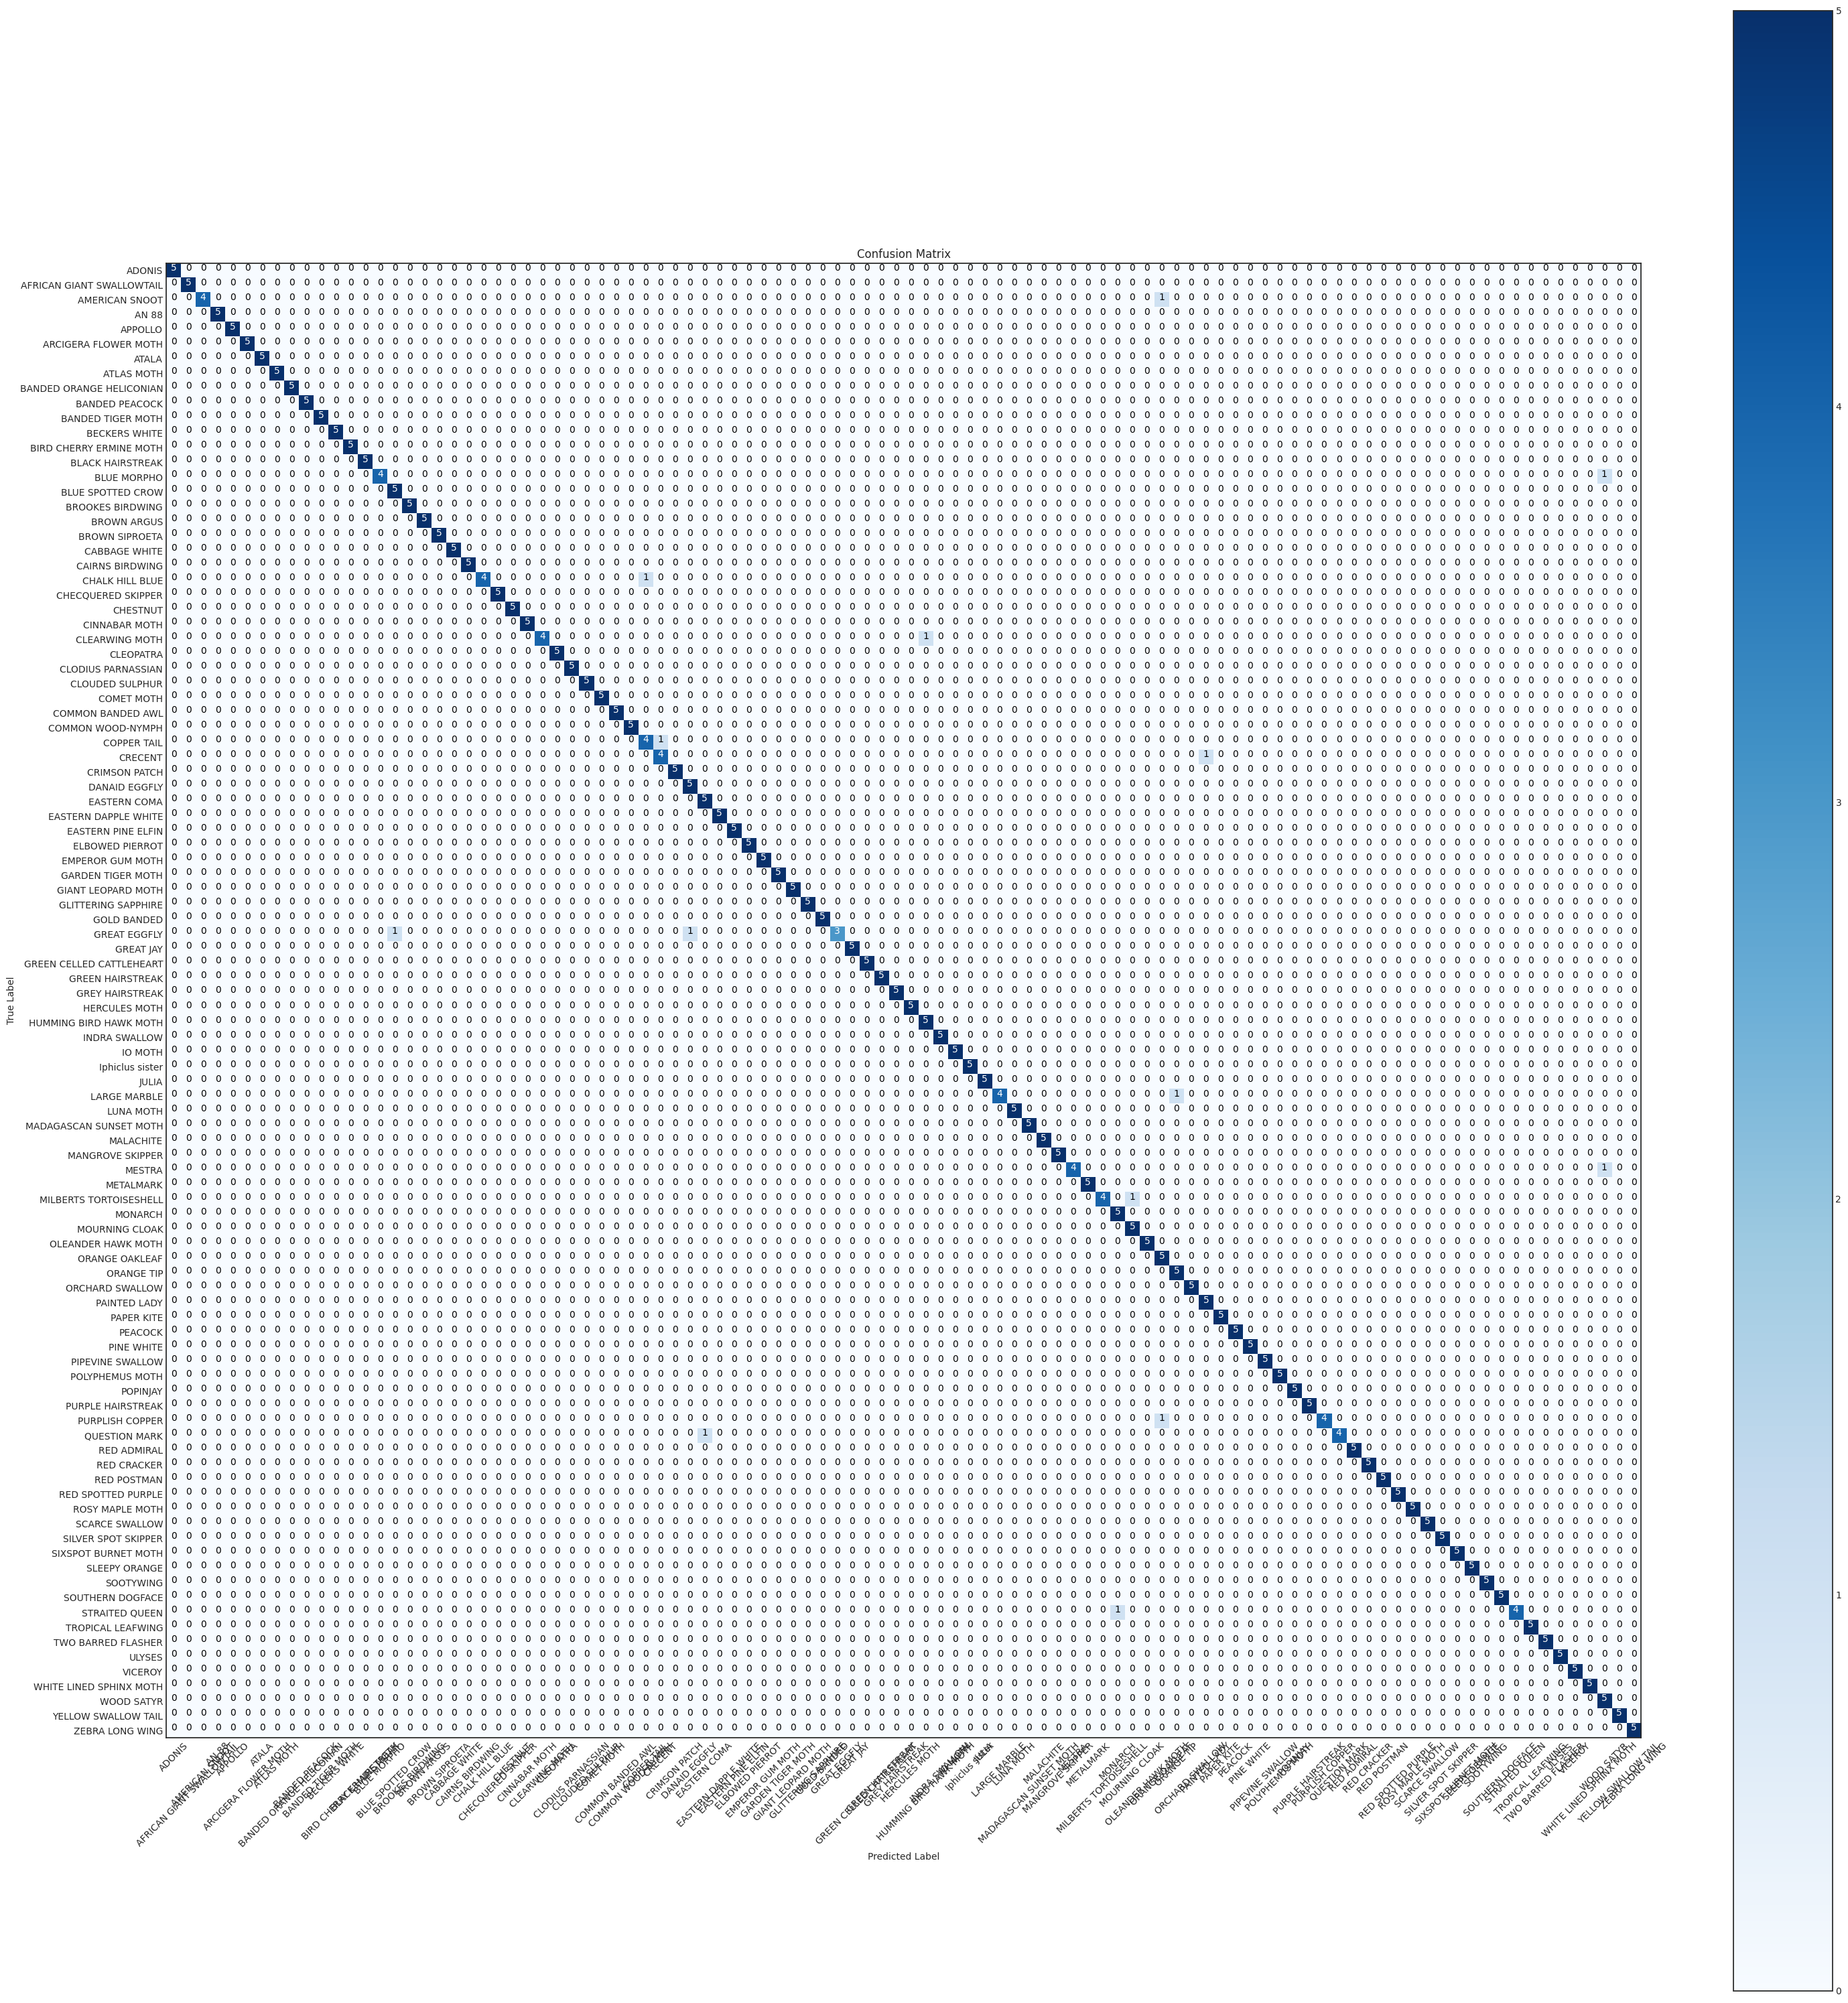

Classification error:  2.8 %


In [46]:
import itertools

plt.figure(figsize= (30, 30))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation= 45)
plt.yticks(tick_marks, class_names)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()
print("Classification error: ", np.round((1-np.sum(np.diag(cm))/np.shape(test_df)[0])*100,2),"%")

In [47]:
tabfinale = classification_report(y_test, y_pred, target_names=class_names,output_dict=True)
df_classification_report = pd.DataFrame(tabfinale).transpose()
df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=True)
print(df_classification_report)
list_labels1 = []
for i in range(0,101):
    if(df_classification_report['f1-score'][i]!=1):
        list_labels1.append(df_classification_report.index.tolist()[i])
list_show1 = list_labels1[0:8]

                          precision  recall  f1-score  support
GREAT EGGFLY               1.000000     0.6  0.750000      5.0
COPPER TAIL                0.800000     0.8  0.800000      5.0
CRECENT                    0.800000     0.8  0.800000      5.0
WOOD SATYR                 0.714286     1.0  0.833333      5.0
ORANGE OAKLEAF             0.714286     1.0  0.833333      5.0
...                             ...     ...       ...      ...
GREEN CELLED CATTLEHEART   1.000000     1.0  1.000000      5.0
GREAT JAY                  1.000000     1.0  1.000000      5.0
BROOKES BIRDWING           1.000000     1.0  1.000000      5.0
IO MOTH                    1.000000     1.0  1.000000      5.0
ADONIS                     1.000000     1.0  1.000000      5.0

[103 rows x 4 columns]


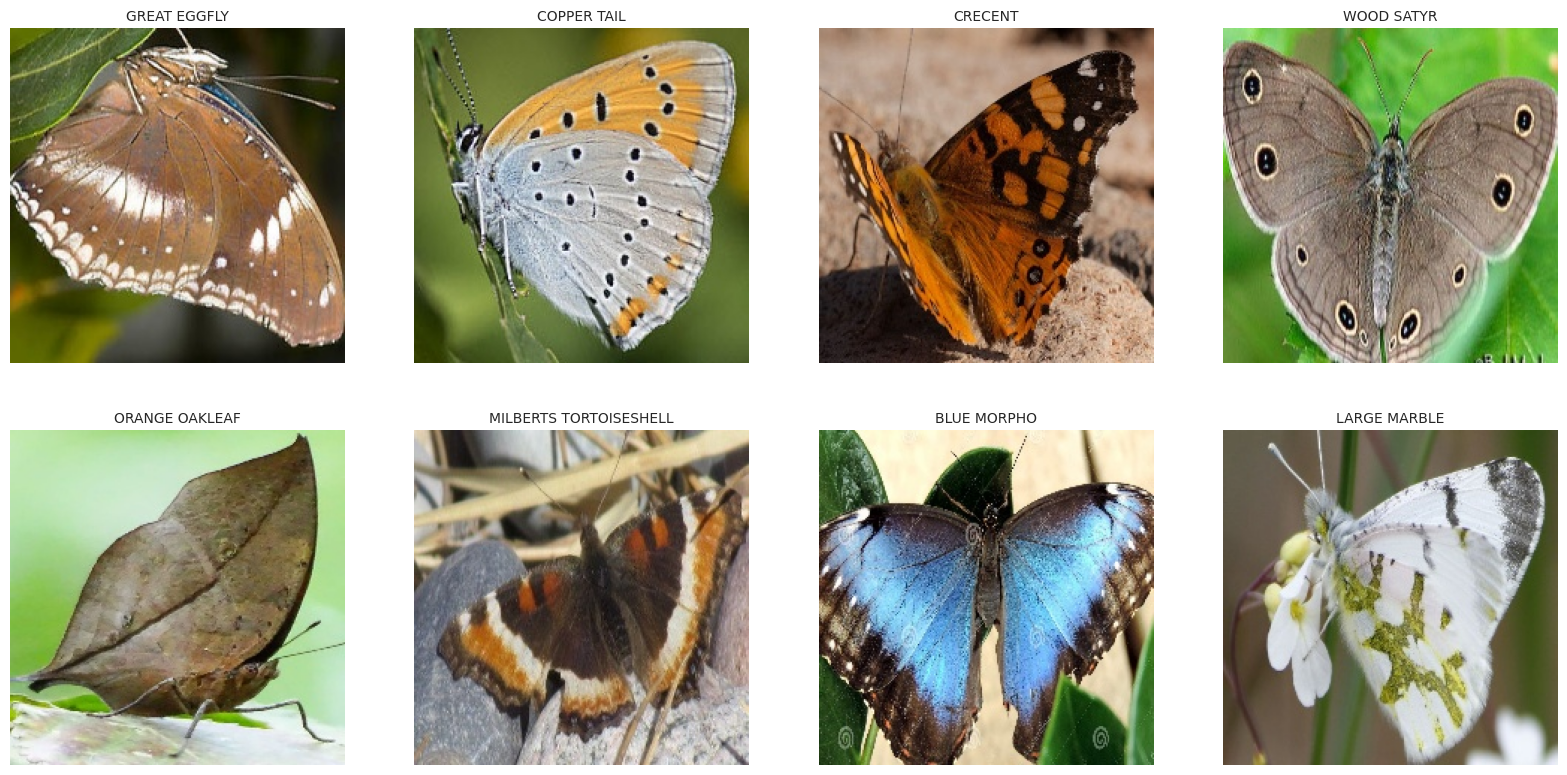

In [48]:
from PIL import Image
plt.figure(figsize=(20,20))
for i in range(0,len(list_show1)):
    plt.subplot(4,4,i+1)
    image_path = "/kaggle/input/butterfly-images40-species/test/"+list_show1[i]+"/1.jpg"
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(list_show1[i], fontsize=10)
    plt.axis('off')
plt.show()

On constate que le modèle crée à partir de ResNet est plus performant. Le taux d'erreur est deux fois moins important que le modèle crée à partir de MobileNet. 
On remarque que les papillons ayant le score F1 le plus faible sont similaires entre les deux modèles (Copper tail, great egglfy). On en déduit que les deux modèles classifient mal des images similaires. On observe que certains papillons mal classés sont similaires de notre point de vue (par exemple Blue morpho et chack hill blue ci dessus). De plus, d'autres images comme celle du clearwing moth présentent un autre attribut sur l'image, comme une fleur. Cela peut-être la source des erreurs communes.
On note que pour le modèle le plus performant, ResNet, en regardant le colonne précision du rapport de classification, on peut compter neuf espèces pour lesquelles le modèle s'est trompé. En terme de précision, tromper signifie que pour ces 9 espèces, le modèle a identifié au moins une autre image appartenant à une autre espèce comme une de ces 9 espèces. 9 espèces sur 100 peut sembler beaucoup mais la précision de chacune de ces 9 espèces reste elevée, donc en moyenne le modèle performe bien. Il n'y a pas une seule espèce pour laquelle le modèle se trompe de manière consistente, et c'est un point fort dans le but d'identifier des espèces de papillons.

Globalement, dans le but d'identifier des espèces de papillons, il peut-être plus important de vouloir à tout prix identifier une espèce présente (pour ne pas rater d'espèces rares par exemple), plutôt que se tromper d'identification. Selon le contexte de l'étude, il peut-être plus pertinent de regarder le recall que la precision.

Ce travail d'identification automatique d'espèces de papillons s'applique sous la forme de camera trap. Concrètement, c'est un appareil photo placé devant un voile blanc qui prend des photos de manière régulière. Cela crée une quantité impressionnante de photos à traiter, où seul l'utilisation d'un modèle de deep learning comme ceux créer plus haut permet d'identifier toutes les espèces présentes. En plaçant des pièges à divers localisations, cela permet d'évaluer rapidement la diversité et la composition des communautés de lépidoptères. 